In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.stats import percentileofscore, pearsonr, spearmanr
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.stattools import grangercausalitytests, adfuller, coint
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.regression.linear_model import OLS
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform
from sklearn.decomposition import PCA
import statsmodels.api as sm
import os
from matplotlib.cm import coolwarm, get_cmap
from statsmodels.tools.tools import add_constant
from matplotlib.colors import Normalize

In [180]:
def loadPrices():
    fn="../prices.txt"
    global nt, nInst
    df=pd.read_csv(fn, sep=r'\s+', header=None, index_col=None)
    (nt,nInst) = df.shape
    return nt, nInst, (df.values).T

In [181]:
# import data
(nt, nInst, prcAll) = loadPrices()
prcTest = prcAll[:, :450]
prcCheck = prcAll[:, 450:600]
prcEval = prcAll[:, 600:]
prcEvalPrev = prcAll
prcCheckPrev = prcAll[:, :600]

In [182]:
# Summary: What Pearson Correlation on Log Returns Really Means
# You're asking: "When Asset A moves up or down more than usual, does Asset B also tend to move in the same direction, at the same time, and by how much?"

# By using log returns instead of prices: You're removing trend and scale, and looking purely at the rhythm of movement between two instruments.
def spearman_correlation_from_prices(prices_a, prices_b, use_log_returns=True):
    """
    Computes Spearman correlation between two price series.

    Parameters:
        prices_a (np.ndarray): Price series A (1D)
        prices_b (np.ndarray): Price series B (1D)
        use_log_returns (bool): If True, use log returns; else use percent returns

    Returns:
        corr (float): Spearman correlation coefficient
        pval (float): p-value associated with the correlation
    """
    # Convert to returns
    if use_log_returns:
        returns_a = np.diff(np.log(prices_a))
        returns_b = np.diff(np.log(prices_b))
    else:
        returns_a = np.diff(prices_a) / prices_a[:-1]
        returns_b = np.diff(prices_b) / prices_b[:-1]

    # Align lengths in case of mismatch
    min_len = min(len(returns_a), len(returns_b))
    returns_a = returns_a[:min_len]
    returns_b = returns_b[:min_len]

    # Compute Spearman correlation
    corr, pval = spearmanr(returns_a, returns_b)
    return corr, pval
def drop_nan_aligned(a, b):
    """
    Drop all elements where either `a` or `b` has NaN, keeping time alignment.

    Parameters:
        a (np.ndarray): 1D array
        b (np.ndarray): 1D array

    Returns:
        a_clean, b_clean: cleaned arrays of same length
    """
    a = np.asarray(a)
    b = np.asarray(b)

    # Build mask where neither a nor b is NaN
    mask = ~np.isnan(a) & ~np.isnan(b)

    return a[mask], b[mask]

def compute_correlation_matrix(prc_matrix, 
                               smooth=False, 
                               smooth_window=5, 
                               use_log_returns=True, 
                               method="pearson"):
    """
    Computes correlation and p-value matrices from returns (log or percentage),
    with optional smoothing and method choice between Pearson and Spearman.

    Parameters:
        prc_matrix (ndarray): (n_instruments, n_days) price matrix
        smooth (bool): Whether to smooth returns before correlation
        smooth_window (int): Window size for smoothing
        use_log_returns (bool): If True, use log returns; else use percentage returns
        method (str): "pearson" (default) or "spearman"

    Returns:
        corr_matrix (ndarray): Correlation coefficients matrix
        pval_matrix (ndarray): P-value matrix
    """
    n = prc_matrix.shape[0]

    # Calculate returns
    if use_log_returns:
        returns = np.diff(np.log(prc_matrix), axis=1)
    else:
        returns = np.diff(prc_matrix, axis=1) / prc_matrix[:, :-1]

    # Optional smoothing
    if smooth:
        kernel = np.ones(smooth_window) / smooth_window
        returns = np.array([
            np.convolve(r, kernel, mode='valid')
            for r in returns
        ])

    # Prepare matrices
    corr_matrix = np.zeros((n, n))
    pval_matrix = np.zeros((n, n))

    # Compute correlations
    for i in range(n):
        for j in range(n):
            if i == j:
                corr_matrix[i, j] = 1.0
                pval_matrix[i, j] = 0.0
            else:
                r1, r2 = drop_nan_aligned(returns[i], returns[j])
                if method == "pearson":
                    r, p = pearsonr(r1, r2)
                elif method == "spearman":
                    r, p = spearmanr(r1, r2)
                else:
                    raise ValueError("Method must be 'pearson' or 'spearman'")
                corr_matrix[i, j] = r
                pval_matrix[i, j] = p

    return corr_matrix, pval_matrix

def plot_correlation_heatmap(corr_matrix, title="Correlation Matrix Heatmap"):
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        corr_matrix,
        cmap='coolwarm',       # red = negative, blue = positive
        vmin=-1, vmax=1,       # range of correlation values
        center=0,
        square=True,
        cbar_kws={'shrink': .6},
        xticklabels=False,
        yticklabels=False
    )
    plt.title(title, fontsize=16)
    plt.tight_layout()
    plt.show()

def plot_fdr_significant_correlation_heatmap(corr_matrix, pval_matrix, alpha=0.05, title="FDR-Significant Correlation Heatmap"):
    """
    Plots a heatmap of the correlation matrix, masking correlations that are not
    statistically significant after FDR correction.

    Parameters:
        corr_matrix (ndarray): Correlation coefficient matrix (n x n)
        pval_matrix (ndarray): Corresponding p-value matrix (n x n)
        alpha (float): FDR-adjusted significance threshold (default = 0.05)
        title (str): Plot title
    """
    # Flatten and correct p-values using FDR (Benjamini-Hochberg)
    flat_pvals = pval_matrix.flatten()
    rejected, corrected_pvals = fdrcorrection(flat_pvals, alpha=alpha)

    # Reshape rejection mask to original matrix shape
    fdr_mask = ~rejected.reshape(pval_matrix.shape)  # Mask = not significant
    np.fill_diagonal(fdr_mask, True)  # Always mask diagonal

    # Plot heatmap with non-significant values masked
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        corr_matrix,
        mask=fdr_mask,
        cmap='coolwarm',
        vmin=-1, vmax=1,
        center=0,
        square=True,
        cbar_kws={'shrink': .6},
        xticklabels=False,
        yticklabels=False
    )
    plt.title(f"{title} (α = {alpha})", fontsize=16)
    plt.tight_layout()
    plt.show()
    
def adjust_pvals_fdr(pval_matrix, alpha=0.05):
    """
    Applies FDR correction to a p-value matrix and returns a boolean mask of significance.
    """
    pvals_flat = pval_matrix.flatten()
    rejected, pvals_corrected = fdrcorrection(pvals_flat, alpha=alpha)
    return rejected.reshape(pval_matrix.shape)

def plot_significant_correlation_heatmap(corr_matrix, pval_matrix, alpha=0.05, title="Significant Correlation Heatmap"):
    """
    Plots a heatmap of the correlation matrix, masking non-significant correlations.

    Parameters:
        corr_matrix (ndarray): Correlation coefficient matrix
        pval_matrix (ndarray): Corresponding p-value matrix
        alpha (float): Significance level (default = 0.05)
        title (str): Plot title
    """
    import seaborn as sns
    import matplotlib.pyplot as plt

    # Create a mask for non-significant values (p > alpha)
    mask = (pval_matrix > alpha)

    # Optionally mask the diagonal too (self-correlations always = 1)
    np.fill_diagonal(mask, True)

    plt.figure(figsize=(12, 10))
    sns.heatmap(
        corr_matrix,
        mask=mask,
        cmap='coolwarm',
        vmin=-1, vmax=1,
        center=0,
        square=True,
        cbar_kws={'shrink': .6},
        xticklabels=False,
        yticklabels=False
    )
    plt.title(f"{title} (α = {alpha})", fontsize=16)
    plt.tight_layout()
    plt.show()
    
def get_top_correlated_pairs(corr_matrix, top_n=5):
    """
    Returns the top N most strongly positively correlated instrument index pairs
    from a correlation matrix (excluding diagonal/self-correlations).

    Parameters:
        corr_matrix (ndarray): A symmetric NxN correlation matrix
        top_n (int): Number of top pairs to return

    Returns:
        List of tuples: (instrument_i, instrument_j, correlation)
    """
    # Get indices of upper triangle, excluding diagonal
    n = corr_matrix.shape[0]
    upper_tri_indices = np.triu_indices(n, k=1)

    # Extract the upper triangle values and corresponding index pairs
    corr_values = corr_matrix[upper_tri_indices]
    index_pairs = list(zip(upper_tri_indices[0], upper_tri_indices[1]))

    # Sort by correlation values descending
    sorted_pairs = sorted(zip(index_pairs, corr_values), key=lambda x: x[1], reverse=True)

    # Return top N
    return [(i, j, round(val, 4)) for ((i, j), val) in sorted_pairs[:top_n]]

def lead_lag_correlation_heatmap(returns, target_idx=0, max_lag=10, method='pearson'):
    """
    Plots a heatmap of lagged correlations between a target instrument and all others.

    Parameters:
        returns (ndarray): (n_instruments, n_days) return matrix (log or %)
        target_idx (int): Index of the instrument to compare against
        max_lag (int): Max number of lags to check (both positive and negative)
        method (str): 'pearson' or 'spearman'
    """
    n_instr, n_days = returns.shape
    lags = range(-max_lag, max_lag + 1)
    target = (returns[target_idx] - np.mean(returns[target_idx])) / np.std(returns[target_idx])

    corr_matrix = np.zeros((n_instr, len(lags)))

    for i in range(n_instr):
        if i == target_idx:
            corr_matrix[i, :] = np.nan  # skip self
            continue
        series = (returns[i] - np.mean(returns[i])) / np.std(returns[i])
        for j, lag in enumerate(lags):
            if lag < 0:
                x = series[-lag:]
                y = target[:lag]
            elif lag > 0:
                x = series[:-lag]
                y = target[lag:]
            else:
                x = series
                y = target

            if method == 'pearson':
                corr = np.corrcoef(x, y)[0, 1]
            elif method == 'spearman':
                from scipy.stats import spearmanr
                corr, _ = spearmanr(x, y)
            else:
                raise ValueError("Unsupported method")
            corr_matrix[i, j] = corr

    # Plot heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, cmap='coolwarm', center=0,
                xticklabels=list(lags), yticklabels=[f"Instr {i}" for i in range(n_instr)])
    plt.title(f"Lag Correlation with Instrument {target_idx}", fontsize=16)
    plt.xlabel("Lag (days)")
    plt.ylabel("Other Instruments")
    plt.tight_layout()
    plt.show()

def lead_lag_correlation_heatmap_with_mask(
    returns,
    target_idx=0,
    max_lag=10,
    method='pearson',
    corr_threshold=0.0,
    tickers=None
):
    """
    Computes and plots lead-lag correlation heatmap between a target instrument and all others,
    with masking based on a correlation threshold.

    Parameters:
        returns (ndarray): (n_instruments, n_days) return matrix
        target_idx (int): Index of the target instrument
        max_lag (int): Max lag (both positive and negative)
        method (str): 'pearson' or 'spearman'
        corr_threshold (float): Minimum |correlation| to show
        tickers (list of str, optional): Ticker labels for instruments

    Returns:
        corr_matrix (ndarray): Full lag correlation matrix
        mask (ndarray): Boolean mask (True = hidden)
    """
    n_instr, n_days = returns.shape
    lags = range(-max_lag, max_lag + 1)
    target = (returns[target_idx] - np.mean(returns[target_idx])) / np.std(returns[target_idx])

    corr_matrix = np.zeros((n_instr, len(lags)))

    for i in range(n_instr):
        if i == target_idx:
            corr_matrix[i, :] = np.nan
            continue

        series = (returns[i] - np.mean(returns[i])) / np.std(returns[i])

        for j, lag in enumerate(lags):
            if lag < 0:
                x = series[-lag:]
                y = target[:lag]
            elif lag > 0:
                x = series[:-lag]
                y = target[lag:]
            else:
                x = series
                y = target

def lead_lag_correlation_heatmap_with_mask(
    returns,
    target_idx=0,
    max_lag=10,
    method='pearson',
    corr_threshold=0.0,
    tickers=None
):
    """
    Computes and plots lead-lag correlation heatmap between a target instrument and all others,
    with masking based on a correlation threshold and proper NaN handling.

    Parameters:
        returns (ndarray): (n_instruments, n_days) return matrix
        target_idx (int): Index of the target instrument
        max_lag (int): Max lag (both positive and negative)
        method (str): 'pearson' or 'spearman'
        corr_threshold (float): Minimum |correlation| to show
        tickers (list of str, optional): Ticker labels for instruments

    Returns:
        corr_matrix (ndarray): Full lag correlation matrix
        mask (ndarray): Boolean mask (True = hidden)
    """
    n_instr, n_days = returns.shape
    lags = range(-max_lag, max_lag + 1)
    corr_matrix = np.full((n_instr, len(lags)), np.nan)

    # Normalize target series
    target = returns[target_idx]
    target = (target - np.nanmean(target)) / np.nanstd(target)

    for i in range(n_instr):
        if i == target_idx:
            continue

        series = returns[i]
        series = (series - np.nanmean(series)) / np.nanstd(series)

        for j, lag in enumerate(lags):
            if lag < 0:
                x = series[-lag:]
                y = target[:lag]
            elif lag > 0:
                x = series[:-lag]
                y = target[lag:]
            else:
                x = series
                y = target

            # Drop NaNs pairwise
            valid_mask = ~np.isnan(x) & ~np.isnan(y)
            x_clean = x[valid_mask]
            y_clean = y[valid_mask]

            if len(x_clean) < 3:  # Not enough data to correlate
                continue

            if method == 'pearson':
                corr = np.corrcoef(x_clean, y_clean)[0, 1]
            elif method == 'spearman':
                corr, _ = spearmanr(x_clean, y_clean)
            else:
                raise ValueError("Unsupported method: use 'pearson' or 'spearman'")

            corr_matrix[i, j] = corr

    # Mask values below threshold or NaNs
    mask = (np.abs(corr_matrix) < corr_threshold) | np.isnan(corr_matrix)

    # Plot
    plt.figure(figsize=(12, 8))
    sns.heatmap(
        corr_matrix,
        cmap='coolwarm',
        center=0,
        mask=mask,
        xticklabels=lags,
        yticklabels=tickers if tickers else range(n_instr),
        cbar_kws={"label": f"{method.title()} Correlation"},
        linewidths=0.5
    )
    plt.title(f"Lead-Lag {method.title()} Correlation to Instrument {target_idx}")
    plt.xlabel("Lag (Positive = Target Leads)")
    plt.ylabel("Instrument")
    plt.tight_layout()
    plt.show()

    return corr_matrix, mask

def resample_closing_prices(prc_array, n=7):
    """
    Resample daily closing prices into n-day closing prices by taking the last price in each n-day window.

    Parameters:
        prc_array (np.ndarray): shape (n_instruments, n_days)
        n (int): grouping size, e.g. 7 for weekly

    Returns:
        np.ndarray: shape (n_instruments, new_days) with resampled closing prices
    """
    n_instruments, n_days = prc_array.shape
    n_groups = n_days // n  # integer number of groups

    # Trim extra days at the end that don't fit into full groups
    trimmed = prc_array[:, :n_groups * n]

    # Reshape: (n_instruments, n_groups, n)
    reshaped = trimmed.reshape(n_instruments, n_groups, n)

    # Take the last price in each group (simulate close of each period)
    resampled = reshaped[:, :, -1]

    return resampled

def average_windowed_correlation(prc_matrix, 
                                  window_size=7,
                                  method='pearson', 
                                  use_log_returns=True):
    """
    Computes an average correlation matrix by converting daily prices to windowed data 
    with multiple offsets (0 to window_size - 1).

    Parameters:
        prc_matrix (ndarray): (n_instruments, n_days) daily price matrix
        window_size (int): number of days in each window (e.g. 7 for weekly, 30 for monthly)
        method (str): 'pearson' or 'spearman'
        use_log_returns (bool): Use log returns (True) or percent returns (False)

    Returns:
        avg_corr_matrix (ndarray): Averaged correlation matrix (n_instruments x n_instruments)
    """
    n_instruments, n_days = prc_matrix.shape
    all_corrs = []

    for offset in range(window_size):
        # Step 1: Resample using window size and offset
        idx = np.arange(offset, n_days, window_size)
        if len(idx) < 3:
            continue  # skip if not enough data points

        windowed_prices = prc_matrix[:, idx]

        # Step 2: Compute returns
        if use_log_returns:
            returns = np.diff(np.log(windowed_prices), axis=1)
        else:
            returns = np.diff(windowed_prices, axis=1) / windowed_prices[:, :-1]

        # Step 3: Compute correlation matrix
        corr_matrix = np.zeros((n_instruments, n_instruments))
        for i in range(n_instruments):
            for j in range(n_instruments):
                if i == j:
                    corr_matrix[i, j] = 1.0
                else:
                    if method == 'pearson':
                        r, _ = pearsonr(returns[i], returns[j])
                    elif method == 'spearman':
                        r, _ = spearmanr(returns[i], returns[j])
                    else:
                        raise ValueError("method must be 'pearson' or 'spearman'")
                    corr_matrix[i, j] = r

        all_corrs.append(corr_matrix)

    avg_corr_matrix = np.mean(all_corrs, axis=0)
    return avg_corr_matrix

In [183]:
# APPLYING SAME TECHNIQUES TO NVIDIA AND AMD
import yfinance as yf

def fetch_closing_prices(tickers, days=450):
    """
    Fetch closing prices for given tickers over the last N trading days.
    
    Parameters:
        tickers (list of str): e.g., ['NVDA', 'AMD']
        days (int): number of trading days (~450 = ~2 calendar years)
        
    Returns:
        DataFrame: (days, tickers) with closing prices
    """
    data = yf.download(tickers, period=f"{int(days * 1.5)}d")['Close']  # fetch ~1.5x to ensure enough trading days
    data = data.dropna()
    return data.head(days)

def fetch_weekly_closing_prices(tickers, weeks=64):
    """
    Fetch weekly closing prices for given tickers over the last N weeks.
    
    Parameters:
        tickers (list of str): e.g., ['NVDA', 'AMD']
        weeks (int): number of weeks to fetch (default ~64 weeks ≈ 1.25 years)
        
    Returns:
        DataFrame: (weeks, tickers) with weekly closing prices (Friday close)
    """
    days_to_fetch = int(weeks * 7 * 1.5)  # fetch more calendar days to ensure enough weeks
    data = yf.download(tickers, period=f"{days_to_fetch}d")['Close']
    
    # Resample to weekly frequency - take last closing price of each week (Friday)
    weekly_data = data.resample('W-FRI').last()
    
    # Take only the most recent N weeks
    return weekly_data.head(weeks)

def add_noise_to_matrix(matrix, noise_std=0.01, seed=None):
    """
    Adds Gaussian noise to each time series in a 2D matrix.

    Parameters:
        matrix (ndarray): shape (n_series, n_timepoints), each row is a time series
        noise_std (float): Standard deviation of the noise
        seed (int or None): Random seed for reproducibility

    Returns:
        noisy_matrix (ndarray): same shape as input, with added noise
    """
    if seed is not None:
        np.random.seed(seed)

    noise = np.random.normal(loc=0.0, scale=noise_std, size=matrix.shape)
    return matrix + noise



In [195]:
### CREATING STARTING DATA!

tickers = [
    'NVDA', 'AMD',             # Core
    'PG', 
    # 'LOT.AX', 'MAQ.AX'
    # 'JNJ', 'KO', 'MCD', 'WMT', 'BRK-B', 'XOM', 'CVX', 'LMT', 'TGT',  # Unrelated US stocks
    # 'MAQ.AX', 'LOT.AX', 'XRO.AX',  # Australian stocksl
    # 'CCJ', 'UEC', 'URNM' # Uranium-related
]

days = 600
close_df = fetch_closing_prices(tickers, days=days)
close_weekly_df = fetch_weekly_closing_prices(tickers, weeks=days//7)
prc_matrix = close_df.T.to_numpy()
prc_matrix_noise = add_noise_to_matrix(prc_matrix, noise_std=0.5, seed=42)
prc_weekly_matrix = close_weekly_df.T.to_numpy()


prcCheckPrev = np.vstack((prcCheckPrev, prc_matrix, prc_matrix_noise))
data_d = np.vstack((prcTest, prc_matrix[:, :450], prc_matrix_noise[:, :450]))
# data_d = prcTest
# data_w = resample_closing_prices(data_d, 14)
# data = data_d

# DATA LAYOUT #
# 0-49 instruments
# 50, 51, 52 acc NVDA and AMD CTVA
# 53, 54, 55 noised NVDA and AMD and CTVA

C:\Users\Aleksander\AppData\Local\Temp\ipykernel_16860\3370504634.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, period=f"{int(days * 1.5)}d")['Close']  # fetch ~1.5x to ensure enough trading days
[*********************100%***********************]  3 of 3 completed
C:\Users\Aleksander\AppData\Local\Temp\ipykernel_16860\3370504634.py:31: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, period=f"{days_to_fetch}d")['Close']
[*********************100%***********************]  3 of 3 completed


In [185]:
print(spearman_correlation_from_prices(*drop_nan_aligned(prc_matrix[0, :], prc_matrix[1, :]), True)[0])
print(spearman_correlation_from_prices(*drop_nan_aligned(prc_matrix_noise[0, :], prc_matrix_noise[1, :]), True)[0])
print(spearman_correlation_from_prices(*drop_nan_aligned(prc_weekly_matrix[0, :], prc_weekly_matrix[1, :]), True)[0])

0.8122626731880709
0.5269179401566713
0.7533259086767237


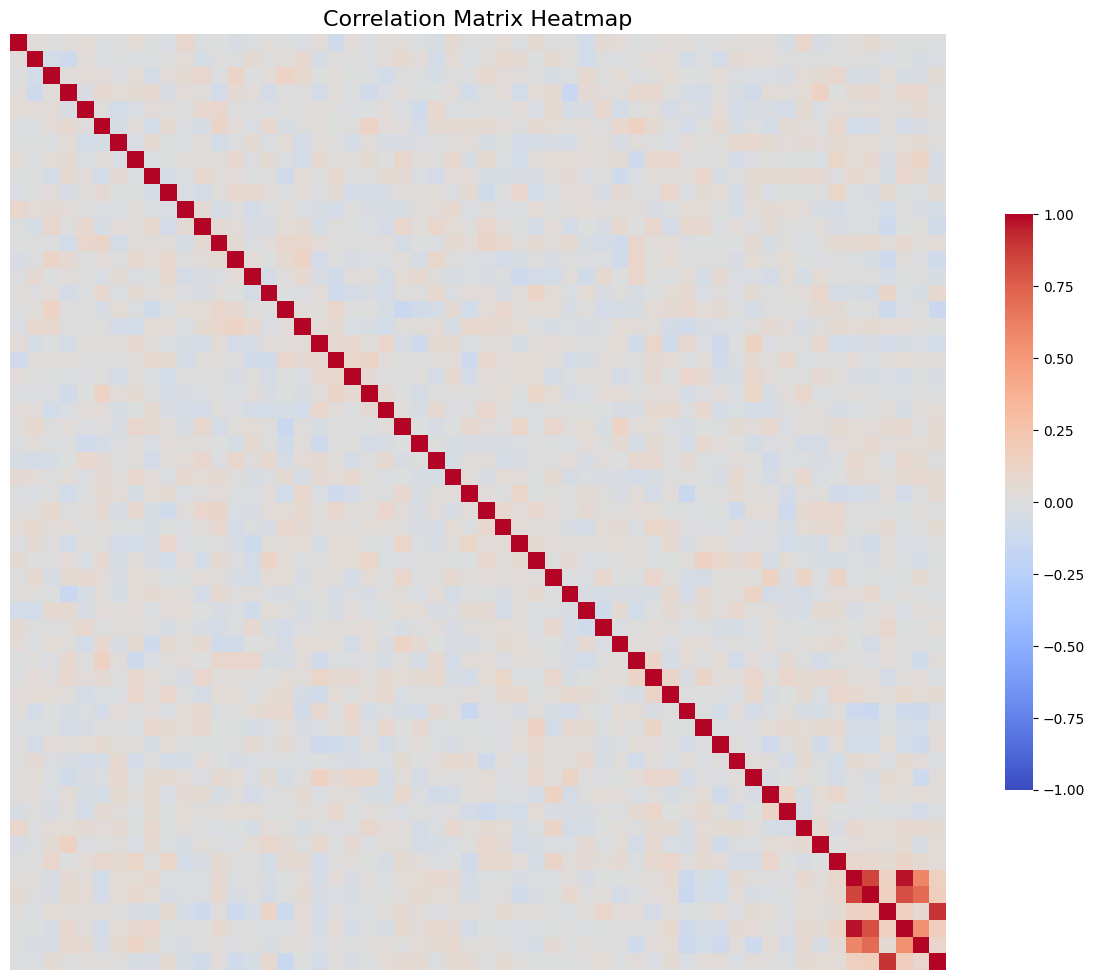

In [186]:

# corr_matrix, pval_matrix = compute_correlation_matrix(data, smooth=True, smooth_window=30, use_log_returns=True, method='spearman')
corr_matrix = average_windowed_correlation(data_d, window_size=1, method='spearman')

plot_correlation_heatmap(corr_matrix)
# plot_significant_correlation_heatmap(corr_matrix, pval_matrix, alpha=0.01)
log_returns = np.diff(np.log(data), axis=1)
# for inst in range(data.shape[0]):
inst = 18
# lead_lag_correlation_heatmap_with_mask(log_returns, target_idx=inst, max_lag=10, method='spearman', corr_threshold=0.00, tickers=None)

# print(get_top_correlated_pairs(corr_matrix, top_n=5))

In [187]:
# Getting Written Correlations
top5 = get_top_correlated_pairs(corr_matrix, top_n=10)
for i, j, val in top5:
    print(f"Instrument {i} & Instrument {j} → Correlation: {val}")

# 50 & 51 nvidia and amd
# noised: nvidia & amd → Correlation: 0.5437

Instrument 50 & Instrument 53 → Correlation: 0.9698
Instrument 52 & Instrument 55 → Correlation: 0.8987
Instrument 50 & Instrument 51 → Correlation: 0.8492
Instrument 51 & Instrument 53 → Correlation: 0.8068
Instrument 51 & Instrument 54 → Correlation: 0.7108
Instrument 50 & Instrument 54 → Correlation: 0.5917
Instrument 53 & Instrument 54 → Correlation: 0.5437
Instrument 51 & Instrument 55 → Correlation: 0.1718
Instrument 53 & Instrument 55 → Correlation: 0.1709
Instrument 52 & Instrument 53 → Correlation: 0.1544


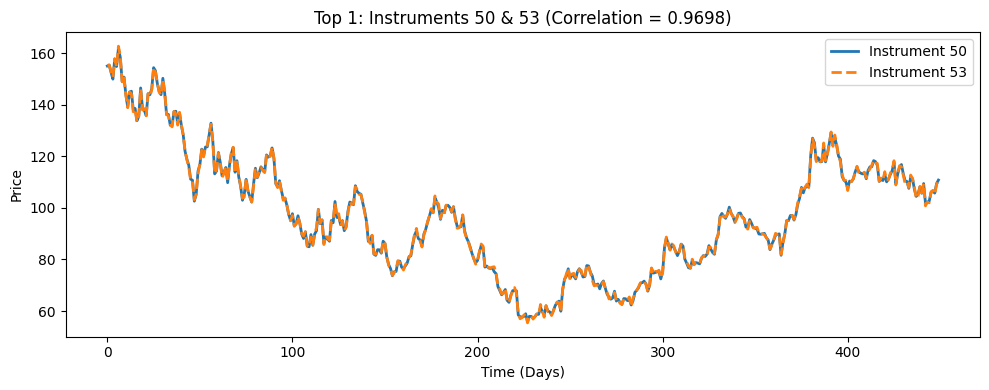

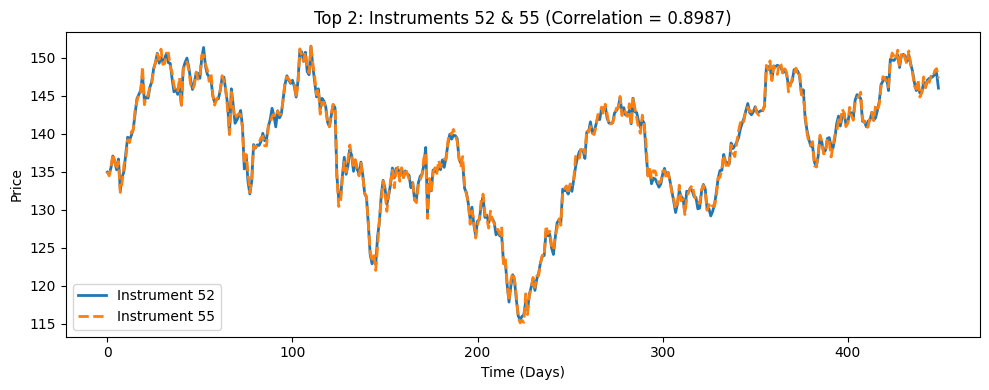

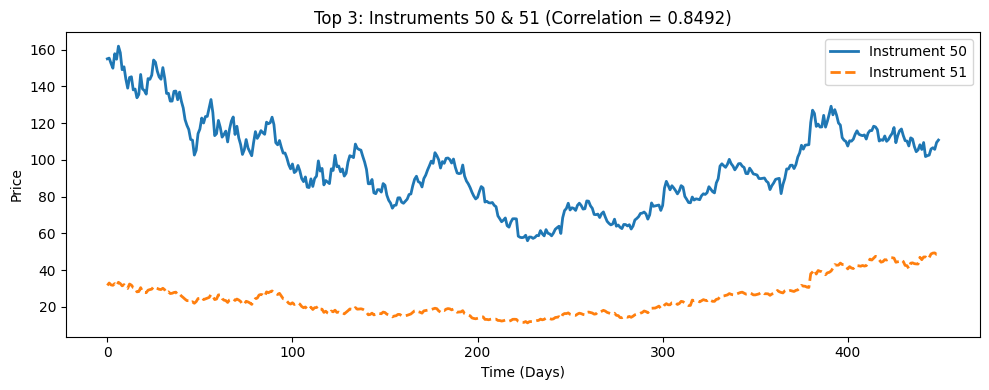

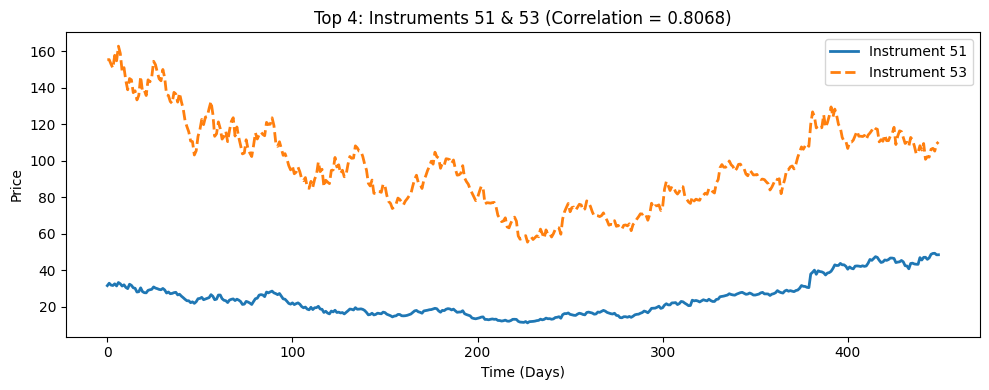

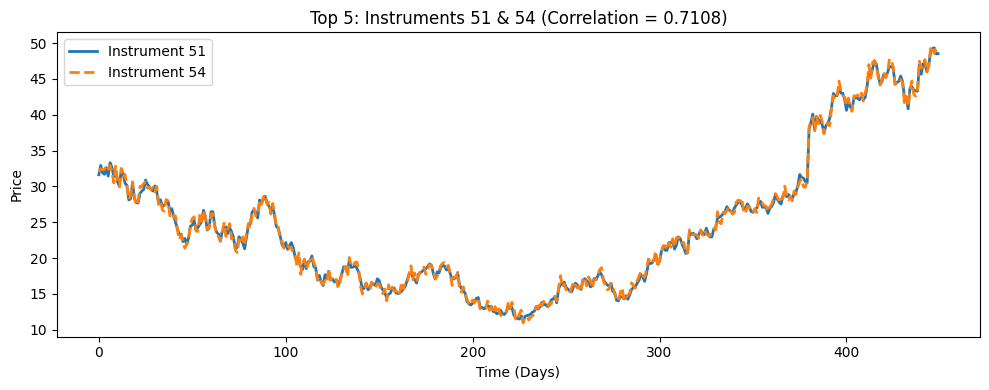

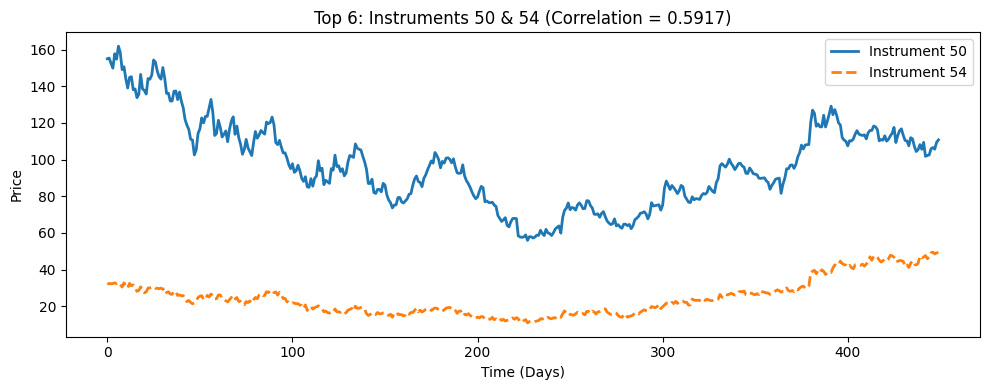

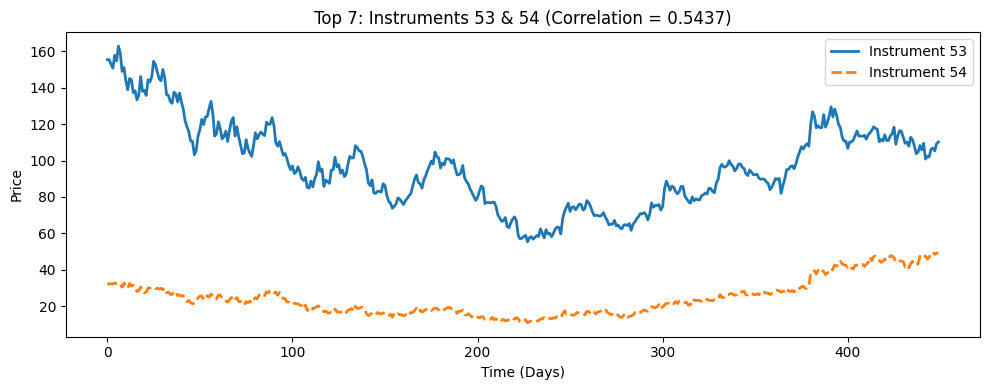

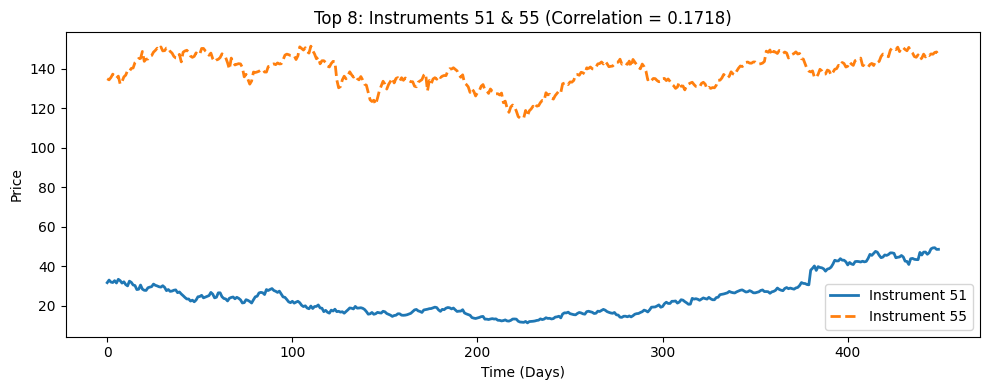

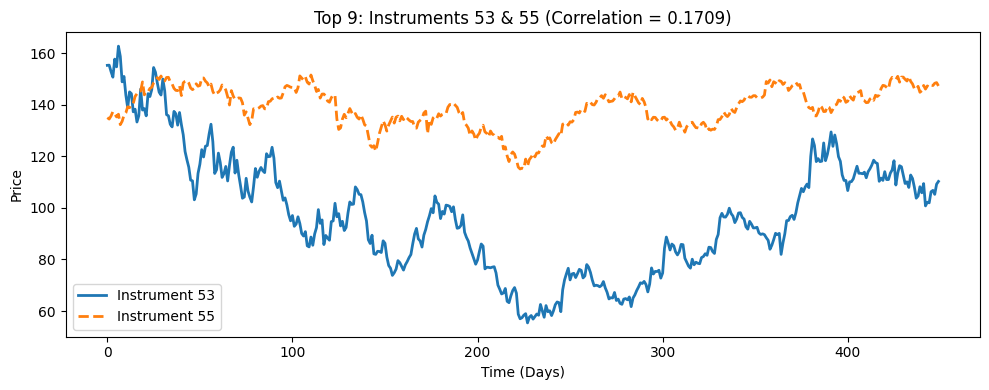

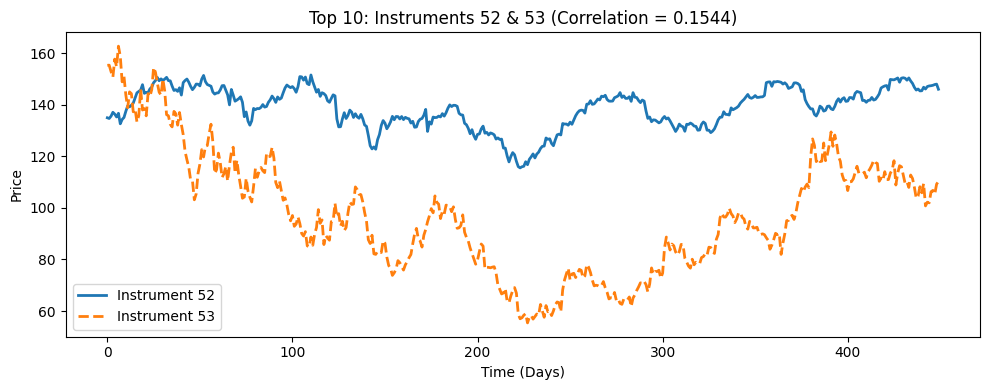

In [188]:
def plot_top_correlated_pairs(prc_matrix, corr_matrix, top_n=5, use_returns=False, smooth=False, smooth_window=5):
    """
    Plots the top N most correlated instrument pairs from a correlation matrix.

    Parameters:
        prc_matrix (ndarray): (instruments, time) closing price matrix
        corr_matrix (ndarray): (instruments, instruments) correlation matrix
        top_n (int): Number of top correlated pairs to plot
        use_returns (bool): If True, plot log returns instead of prices
        smooth (bool): Whether to apply moving average smoothing
        smooth_window (int): Window size for smoothing (in days)
    """
    # Step 1: Get top correlated index pairs
    n = corr_matrix.shape[0]
    upper = np.triu_indices(n, k=1)
    corr_values = corr_matrix[upper]
    index_pairs = list(zip(upper[0], upper[1]))
    sorted_pairs = sorted(zip(index_pairs, corr_values), key=lambda x: x[1], reverse=True)
    top_pairs = sorted_pairs[:top_n]

    # Step 2: Compute returns or use prices
    if use_returns:
        log_prices = np.log(prc_matrix)
        data = np.diff(log_prices, axis=1)
        ylabel = "Log Returns"
    else:
        data = prc_matrix
        ylabel = "Price"

    # Step 3: Optional smoothing
    if smooth:
        # Apply moving average across time axis (axis=1)
        kernel = np.ones(smooth_window) / smooth_window
        data = np.array([
            np.convolve(row, kernel, mode='valid')
            for row in data
        ])
        xlabel = f"Time (Days) [Smoothed, Window={smooth_window}]"
    else:
        xlabel = "Time (Days)"

    # Step 4: Plot each pair
    for idx, ((i, j), corr_val) in enumerate(top_pairs, 1):
        plt.figure(figsize=(10, 4))
        plt.plot(data[i], label=f"Instrument {i}", linewidth=2)
        plt.plot(data[j], label=f"Instrument {j}", linewidth=2, linestyle='--')
        plt.title(f"Top {idx}: Instruments {i} & {j} (Correlation = {corr_val:.4f})")
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.legend()
        plt.tight_layout()
        plt.show()

plot_top_correlated_pairs(data_d, corr_matrix, 10, use_returns=False)

In [189]:
def check_symmetry(matrix):
    rows = len(matrix)
    cols = len(matrix[0])
    
    if rows != cols:
        print("Matrix is not square, so it cannot be symmetric.")
        return

    symmetric = True
    for i in range(rows):
        for j in range(i + 1, cols):  # only need to check above diagonal
            if matrix[i][j] != matrix[j][i]:
                print(f"Mismatch at ({i}, {j}) and ({j}, {i}): {matrix[i][j]} != {matrix[j][i]}")
                symmetric = False
    
    if symmetric:
        print("Matrix is symmetric.")
    else:
        print("Matrix is NOT symmetric.")
corr_matrix == corr_matrix.T
A = corr_matrix
is_symmetric = check_symmetry(A)
is_symmetric

Mismatch at (0, 2) and (2, 0): 0.006268025312455382 != 0.006268025312455383
Mismatch at (0, 8) and (8, 0): -0.005043464894485595 != -0.005043464894485594
Mismatch at (0, 9) and (9, 0): -0.026611446415712534 != -0.02661144641571253
Mismatch at (0, 10) and (10, 0): 0.08645349776880099 != 0.08645349776880097
Mismatch at (0, 11) and (11, 0): -0.009914587815651653 != -0.009914587815651651
Mismatch at (0, 13) and (13, 0): -0.037069282517901515 != -0.03706928251790151
Mismatch at (0, 14) and (14, 0): -0.012235707271845067 != -0.012235707271845066
Mismatch at (0, 15) and (15, 0): 0.020973806903286513 != 0.020973806903286516
Mismatch at (0, 16) and (16, 0): 0.0014302422493765777 != 0.001430242249376578
Mismatch at (0, 18) and (18, 0): 0.031512459521707475 != 0.03151245952170747
Mismatch at (0, 19) and (19, 0): -0.09557247392176649 != -0.09557247392176647
Mismatch at (0, 27) and (27, 0): -0.008106319026985179 != -0.00810631902698518
Mismatch at (0, 30) and (30, 0): -0.012213767225570086 != -0.01

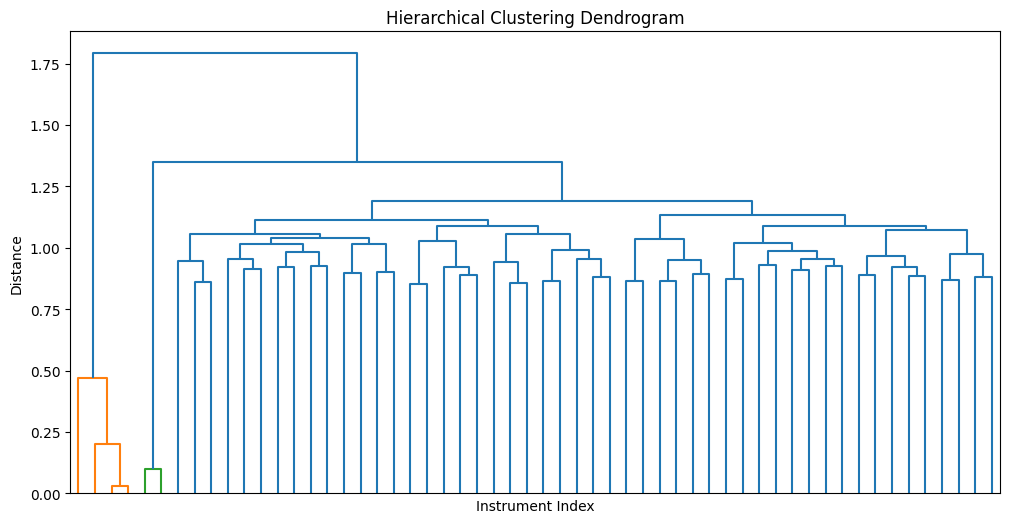

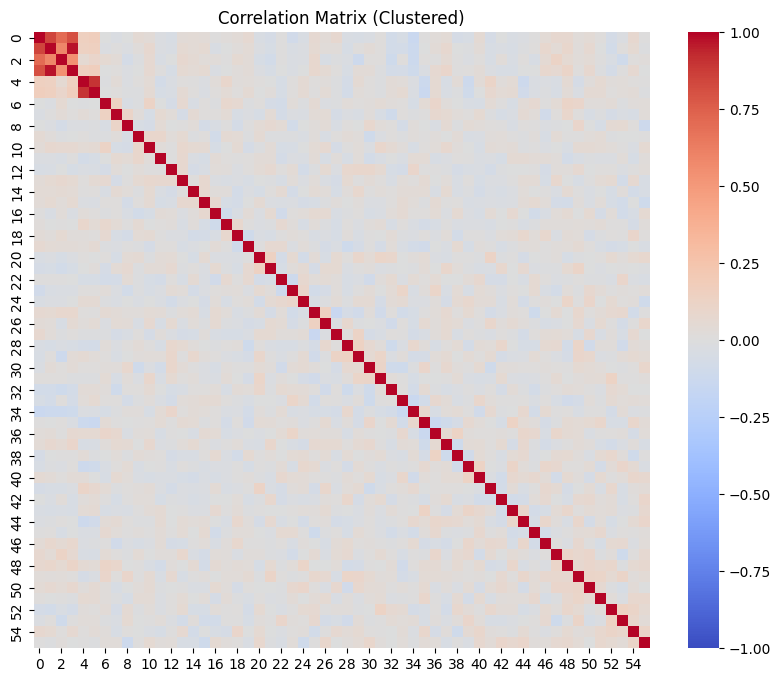

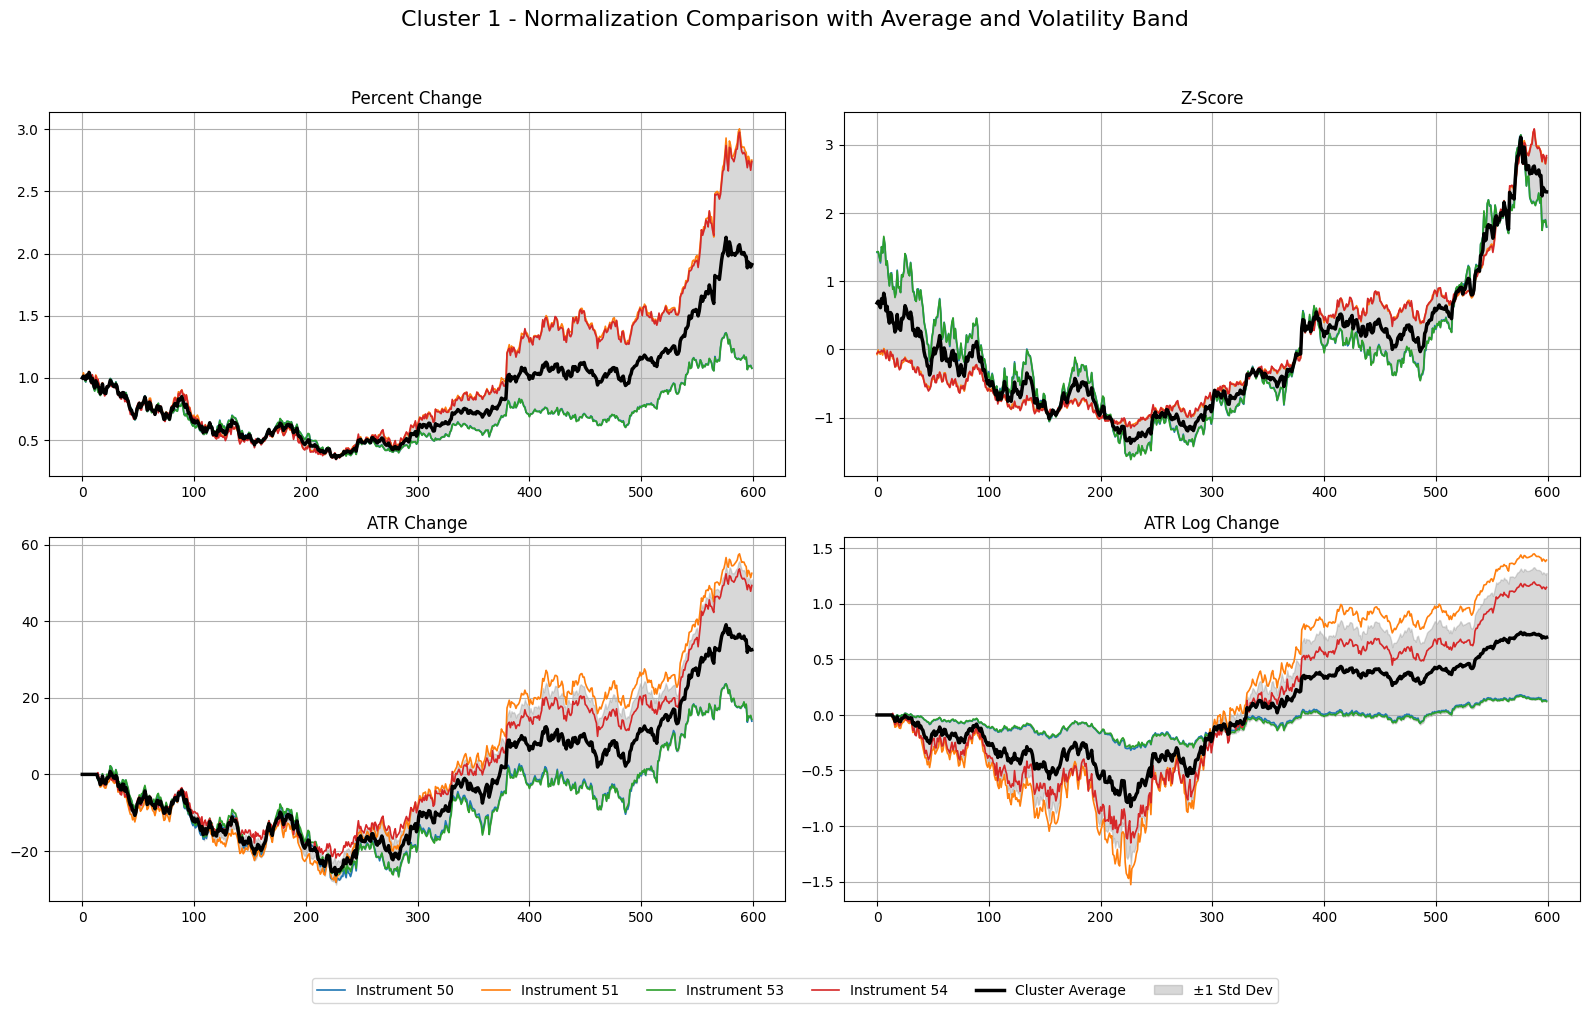

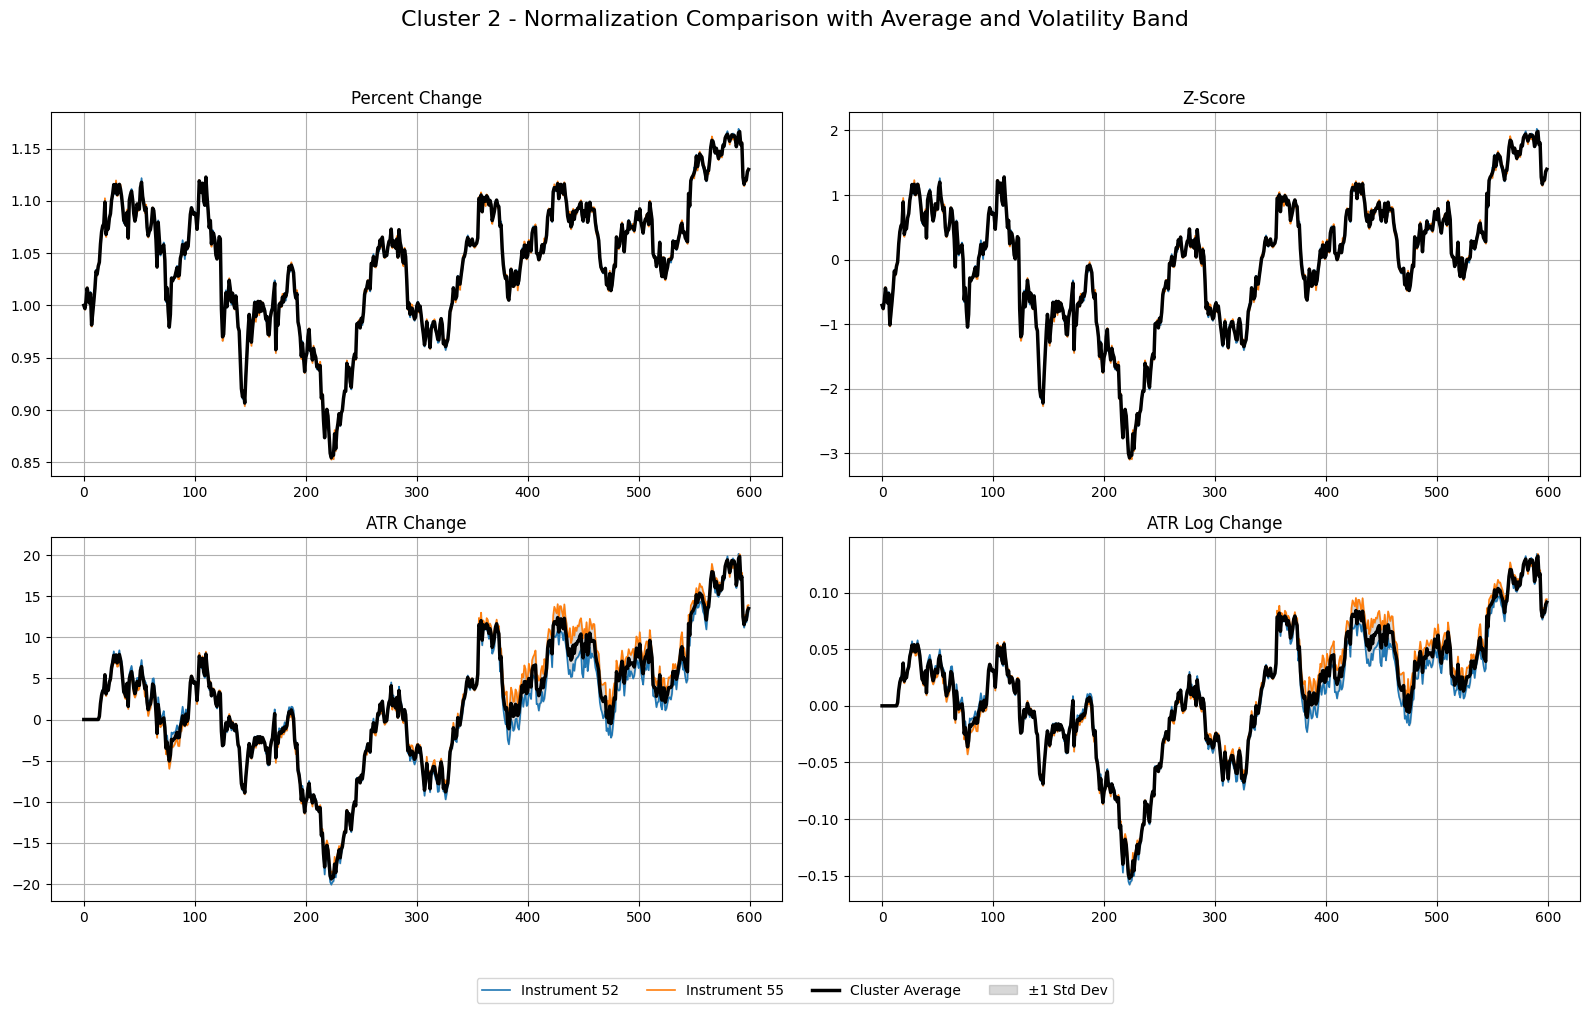

Cluster 3 skipped (singleton or empty).
Cluster 4 skipped (singleton or empty).
Cluster 5 skipped (singleton or empty).
Cluster 6 skipped (singleton or empty).
Cluster 7 skipped (singleton or empty).
Cluster 8 skipped (singleton or empty).
Cluster 9 skipped (singleton or empty).
Cluster 10 skipped (singleton or empty).
Cluster 11 skipped (singleton or empty).
Cluster 12 skipped (singleton or empty).
Cluster 13 skipped (singleton or empty).
Cluster 14 skipped (singleton or empty).
Cluster 15 skipped (singleton or empty).
Cluster 16 skipped (singleton or empty).
Cluster 17 skipped (singleton or empty).
Cluster 18 skipped (singleton or empty).
Cluster 19 skipped (singleton or empty).
Cluster 20 skipped (singleton or empty).
Cluster 21 skipped (singleton or empty).
Cluster 22 skipped (singleton or empty).
Cluster 23 skipped (singleton or empty).
Cluster 24 skipped (singleton or empty).
Cluster 25 skipped (singleton or empty).
Cluster 26 skipped (singleton or empty).
Cluster 27 skipped (sin

In [190]:
# Adjustable Params
cluster_cutoff = 0.5

# Clustering Similar points! Use hierarchical clustering (e.g. Ward's method)
distance_matrix = 1 - np.abs(np.round(corr_matrix, decimals=10))
linkage_matrix = linkage(squareform(distance_matrix), method='ward')

# Plot dendrogram
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, no_labels=True, color_threshold=cluster_cutoff)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Instrument Index")
plt.ylabel("Distance")
plt.show()

clusters = fcluster(linkage_matrix, t=cluster_cutoff, criterion='distance')

# Sort by cluster and Plot!
sorted_idx = np.argsort(clusters)
sorted_corr = corr_matrix[sorted_idx][:, sorted_idx]

plt.figure(figsize=(10, 8))
sns.heatmap(sorted_corr, cmap='coolwarm', vmin=-1, vmax=1, square=True)
plt.title("Correlation Matrix (Clustered)")
plt.show()

# Using PCA to view it visually!
# Transpose to shape (n_samples, n_features) = (50, 449)
# pca = PCA(n_components=2)
# pca_coords = pca.fit_transform(log_returns)
# pca_coords shape: (50, 2)

def compute_atr(prices, window=14):
    """
    Compute Average True Range (ATR) for each price series.
    Assumes prices is a (n_instruments, n_days) ndarray of close prices.
    """
    highs = prices[:, 1:]
    lows = prices[:, :-1]
    closes = prices[:, :-1]
    
    tr = np.abs(highs - lows)  # approximate true range as abs(diff)
    atr = np.zeros_like(prices)
    atr[:, window:] = np.apply_along_axis(
        lambda x: np.convolve(x, np.ones(window)/window, mode='valid'), 
        axis=1, arr=tr
    )
    atr[:, :window] = np.nan  # pad initial values
    return atr

def volatility_normalized_prices(prices, atr_window=14, use_log=False):
    """
    Normalize price series by ATR.
    Returns volatility-adjusted cumulative return.
    """
    if use_log:
        log_returns = np.diff(np.log(prices), axis=1)
    else:
        log_returns = np.diff(prices, axis=1)
    atr = compute_atr(prices, window=atr_window)[:, 1:]  # align shape

    # Avoid divide by zero
    atr[atr == 0] = np.nan
    norm_returns = log_returns / atr

    # Cumulative sum to reconstruct a path
    norm_prices = np.nancumsum(norm_returns, axis=1)
    norm_prices = np.hstack([np.zeros((prices.shape[0], 1)), norm_prices])  # add zero at start

    return norm_prices

def log_returns_normalized_prices(prices):
    log_returns = np.log(prices)
    transformed = log_returns - log_returns[:, [0]]
    return transformed

def z_score_normalized_prices(prices):
    return (prices- prices.mean(axis=1, keepdims=True)) / prices.std(axis=1, keepdims=True)

def percent_change_normalized_prices(prices):
    return prices/ prices[:, [0]]

def plot_pca_projection(pca_coords, clusters):
    n_clusters = len(np.unique(clusters))
    # Step 5: Plot PCA with cluster coloring
    plt.figure(figsize=(10, 8))
    palette = sns.color_palette("hsv", n_clusters)
    for cluster_id in range(1, n_clusters + 1):
        idx = np.where(clusters == cluster_id)[0]
        plt.scatter(
            pca_coords[idx, 0], pca_coords[idx, 1],
            s=80, edgecolor='k', label=f"Cluster {cluster_id}",
            color=palette[cluster_id - 1]
        )
        for i in idx:
            plt.text(pca_coords[i, 0], pca_coords[i, 1], str(i), fontsize=8,
                     ha='center', va='center', color='white', weight='bold')

    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("PCA Projection Colored by Correlation Clusters")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_cluster_all_normalizations(
    data,
    cluster_labels,
    cluster_id,
    save_plot=False,
    output_dir="cluster_all_normalizations",
    tickers=None,
    show_volatility_band=True
):
    """
    Plots a single cluster's price series using 4 normalization methods:
    - Log Percent Change from first value
    - Z-Score normalization
    - ATR Normalised
    - ATR Log Normalised
    Each with a cluster average line and optional volatility band.

    Parameters:
        data (ndarray): (n_instruments, n_days) price matrix
        cluster_labels (ndarray): cluster ID array (len = n_instruments)
        cluster_id (int): The cluster ID to plot
        save_plot (bool): If True, saves the plot to disk
        output_dir (str): Folder to save plots in
        tickers (list of str): Optional list of instrument names
        show_volatility_band (bool): If True, display ±1 std band around cluster average
    """
    idx = np.where(cluster_labels == cluster_id)[0]
    if len(idx) <= 1:
        print(f"Cluster {cluster_id} skipped (singleton or empty).")
        return

    cluster_data = data[idx]
    if tickers is not None:
        tickers = [tickers[i] for i in idx]

    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle(f"Cluster {cluster_id} - Normalization Comparison with Average and Volatility Band", fontsize=16)

    norm_methods = ["Percent Change", "Z-Score", "ATR Change", "ATR Log Change"]

    for k, method in enumerate(norm_methods):
        ax = axes[k // 2, k % 2]

        if method == "Percent Change":
            transformed = percent_change_normalized_prices(cluster_data)
        elif method == "Z-Score":
            transformed = z_score_normalized_prices(cluster_data)
        elif method == "ATR Change":
            transformed = volatility_normalized_prices(cluster_data, 14, False)
        elif method == "ATR Log Change":
            transformed = volatility_normalized_prices(cluster_data, 14, True)
            # returns = np.diff(cluster_data, axis=1) / cluster_data[:, :-1]
            # returns = np.hstack([np.zeros((returns.shape[0], 1)), returns])
            # transformed = np.cumsum(returns, axis=1)

        # Plot individual lines
        for i, series in enumerate(transformed):
            label = tickers[i] if tickers else f"Instrument {idx[i]}"
            ax.plot(series, label=label, linewidth=1.2)

        # Cluster average
        cluster_avg = np.nanmean(transformed, axis=0)
        ax.plot(cluster_avg, label="Cluster Average", linewidth=2.5, color="black", zorder=10)

        # Volatility band (±1 std)
        if show_volatility_band:
            cluster_std = np.nanstd(transformed, axis=0)
            ax.fill_between(
                np.arange(transformed.shape[1]),
                cluster_avg - cluster_std,
                cluster_avg + cluster_std,
                color='gray',
                alpha=0.3,
                label="±1 Std Dev"
            )

        ax.set_title(method)
        ax.grid(True)

    # Legend (outside grid so it's shared across all subplots)
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center', ncol=min(len(labels), 6), bbox_to_anchor=(0.5, -0.02))

    plt.tight_layout(rect=[0, 0.05, 1, 0.95])

    if save_plot:
        os.makedirs(output_dir, exist_ok=True)
        filename = os.path.join(output_dir, f"cluster_{cluster_id}_normalizations.png")
        plt.savefig(filename, dpi=300)
        print(f"Saved to {filename}")

    plt.show()


def plot_clusters_price_series(
    data,
    cluster_labels,
    save_plots=False,
    output_dir="cluster_plots_colored",
    show_colorbar=True,
    color_by_correlation=True,
    normalization_method="percent"
):
    """
    Plots clustered instrument price series with either:
    - heatmap coloring by correlation to cluster average, OR
    - distinct colors for each instrument (default style).

    Parameters:
        data (ndarray): (n_instruments, n_days) price matrix
        cluster_labels (ndarray): cluster ID array (len = n_instruments)
        normalize (bool): Normalize each series to start at 1
        save_plots (bool): Save plots to disk
        output_dir (str): Folder to save plots in (created if not exists)
        show_colorbar (bool): Show correlation colorbar if heatmap used
        color_by_correlation (bool): If True, use heatmap coloring
    """
    unique_clusters = np.unique(cluster_labels)

    if save_plots and not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for cluster_id in unique_clusters:
        idx = np.where(cluster_labels == cluster_id)[0]
        if len(idx) <= 1:
            continue  # skip singleton clusters

        cluster_data = data[idx]

        # Normalize if requested
        if normalization_method == "percent":
            cluster_data = cluster_data / cluster_data[:, [0]]
        elif normalization_method == "zscore":
            cluster_data = (cluster_data - cluster_data.mean(axis=1, keepdims=True)) / cluster_data.std(axis=1, keepdims=True)
        elif normalization_method == "log":
            cluster_data = np.log(cluster_data)
            cluster_data = cluster_data - cluster_data[:, [0]]
        elif normalization_method == "cumulative_return":
            returns = np.diff(cluster_data, axis=1) / cluster_data[:, :-1]
            returns = np.hstack([np.zeros((returns.shape[0], 1)), returns])
            cluster_data = np.cumsum(returns, axis=1)


        avg_series = cluster_data.mean(axis=0)

        # Determine colors
        if color_by_correlation:
            corr_to_avg = []
            for series in cluster_data:
                if np.std(series) == 0 or np.std(avg_series) == 0:
                    corr = 0
                else:
                    corr = np.corrcoef(series, avg_series)[0, 1]
                corr_to_avg.append(corr)
            corr_to_avg = np.clip(corr_to_avg, -1, 1)

            cmap = coolwarm
            norm = Normalize(vmin=-1, vmax=1)
            colors = [cmap(norm(c)) for c in corr_to_avg]
        else:
            # Use a qualitative colormap for distinct colors
            cmap = get_cmap("tab10")  # good for ≤10 items; use 'tab20' for larger clusters
            colors = [cmap(i % cmap.N) for i in range(len(idx))]

        # Plot
        fig, ax = plt.subplots(figsize=(12, 6))
        for i, (series, color) in zip(idx, zip(cluster_data, colors)):
            ax.plot(series, label=f"Instrument {i}", linewidth=1.2, alpha=0.85, color=color)

        ax.plot(avg_series, color='black', linewidth=3, label="Cluster Avg")

        ax.set_title(f"Cluster {cluster_id} — {len(idx)} Instruments")
        ax.set_xlabel("Time (Days)")
        ax.set_ylabel(f"{normalization_method} - Price")
        ax.grid(True)
        ax.legend()

        # Optional colorbar (only for heatmap-style)
        if color_by_correlation and show_colorbar:
            sm = plt.cm.ScalarMappable(cmap=coolwarm, norm=Normalize(vmin=-1, vmax=1))
            sm.set_array([])
            cbar = fig.colorbar(sm, ax=ax, orientation='vertical', shrink=0.8)
            cbar.set_label('Correlation with Cluster Avg', fontsize=10)

        plt.tight_layout()

        if save_plots:
            filename = f"cluster_{cluster_id}.png"
            plt.savefig(os.path.join(output_dir, filename))
            plt.close()
        else:
            plt.show()

# plot_pca_projection(pca_coords, clusters)

# Blue colour represents negatively correlated, higher shades of red represent stronger average correlation
norm_type = "percent"
# for norm_type in ["percent", "zscore", "log", "cumulative_return"]:
for i in range(1, max(clusters)+1):
    plot_cluster_all_normalizations(
        data=prcCheckPrev,
        cluster_labels=clusters,
        cluster_id=i,
        save_plot=False,
        tickers=None,
        show_volatility_band=True
    )
# plot_clusters_price_series(
#     prcCheckPrev,
#     clusters,
#     save_plots=False,
#     output_dir="cluster_charts",
#     show_colorbar=False,
#     color_by_correlation=True,
#     normalization_method=norm_type # percent, zscore, log, cumulative_return
# )

ADF Test on Residuals:
  ADF Statistic: -4.2152
  p-value: 0.0006
  Used Lag: 0
  Observations: 449
  Critical Value (1%): -3.4450
  Critical Value (5%): -2.8680
  Critical Value (10%): -2.5702


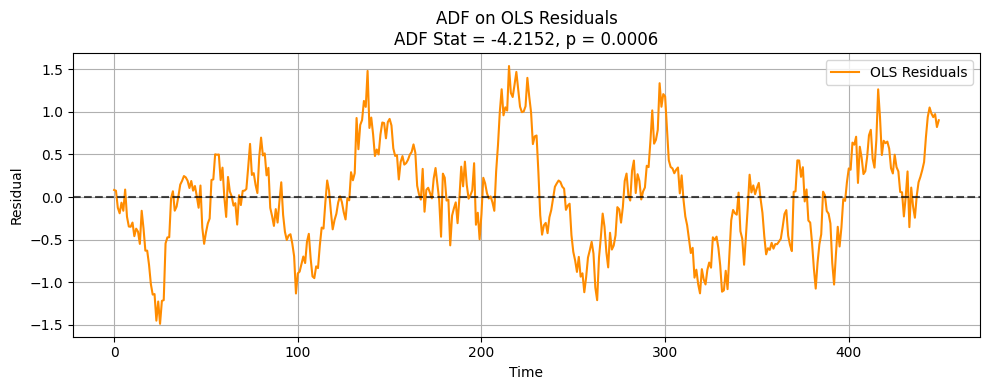

ADF Test on Residuals:
  ADF Statistic: -3.2831
  p-value: 0.0157
  Used Lag: 0
  Observations: 449
  Critical Value (1%): -3.4450
  Critical Value (5%): -2.8680
  Critical Value (10%): -2.5702


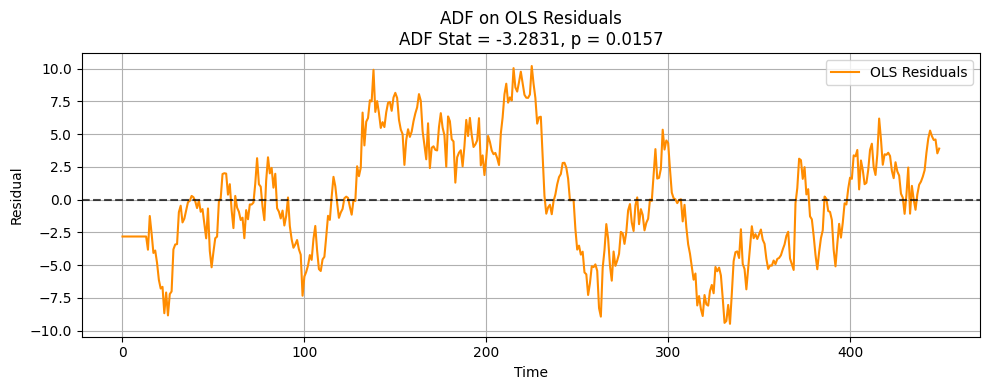

ADF Test on Residuals:
  ADF Statistic: -3.0478
  p-value: 0.0307
  Used Lag: 1
  Observations: 448
  Critical Value (1%): -3.4450
  Critical Value (5%): -2.8680
  Critical Value (10%): -2.5702


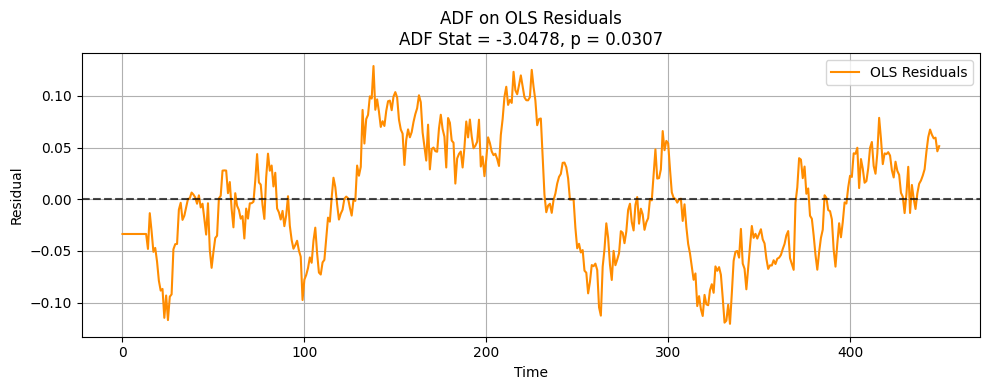

Top 5 cointegrated instruments with instrument 48:
Instrument 25: p-value=0.000575, beta=-0.3464, intercept=92.0618
Instrument 49: p-value=0.000621, beta=0.9473, intercept=49.8128
Instrument 41: p-value=0.004300, beta=0.3326, intercept=61.9088
Instrument 33: p-value=0.004574, beta=-0.7461, intercept=88.2470
Instrument 1: p-value=0.005103, beta=-0.3728, intercept=101.2154


In [ ]:
# Classifying significance of the correlation in terms of stationary mean!
def adf_test_with_plot(series, title="ADF Test"):
    """
    Performs ADF test and plots the input time series.

    Parameters:
        series (array-like): Time series data (1D)
        title (str): Optional title for the plot

    Prints:
        ADF statistic, p-value, and critical values
    """
    result = adfuller(series, autolag='AIC')
    stat, pval, used_lag, n_obs, crit_vals, ic_best = result

    print(f"ADF Statistic: {stat:.4f}")
    print(f"P-value: {pval:.4f}")
    print(f"Used Lag: {used_lag}")
    print(f"Number of Observations: {n_obs}")
    for key, value in crit_vals.items():
        print(f"Critical Value ({key}): {value:.4f}")

    # Plot the series
    plt.figure(figsize=(10, 4))
    plt.plot(series, label="Time Series", color='steelblue')
    plt.title(f"{title}\nADF Stat = {stat:.4f}, p = {pval:.4f}")
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def check_pair_cointegration(prc_pair):
    price_a = prc_pair[0]
    price_b = prc_pair[1]
    # 1. Step: OLS regression
    beta = np.polyfit(price_b, price_a, 1)[0]
    spread = price_a - beta * price_b

    # 2. Step: ADF test on spread
    adf_result = adfuller(spread)
    print("ADF Test on Spread:")
    print(f"ADF Statistic: {adf_result[0]}")
    print(f"P-value: {adf_result[1]}")

    # 3. Step: Cointegration test
    coint_t, p_value, crit = coint(price_a, price_b)
    print("\nEngle-Granger Cointegration Test:")
    print(f"Test Statistic: {coint_t}")
    print(f"P-value: {p_value}")
    print(f"Critical Values: {crit}")

def adf_on_log_ratio(prc_pair, title="ADF on Log Price Ratio"):
    """
    Computes the log ratio of two price series and runs ADF test on it.

    Parameters:
        price_a (array-like): Price series of instrument A
        price_b (array-like): Price series of instrument B
        title (str): Title for the plot
    """
    price_a = prc_pair[0]
    price_b = prc_pair[1]
    # Step 1: Compute log ratio
    log_ratio = np.log(price_a) - np.log(price_b)

    # Step 2: ADF test
    adf_result = adfuller(log_ratio)
    stat, pval, used_lag, n_obs, crit_vals, _ = adf_result

    print(f"ADF Test on log(A/B):")
    print(f"  ADF Statistic: {stat:.4f}")
    print(f"  p-value: {pval:.4f}")
    print(f"  Used Lag: {used_lag}")
    print(f"  Observations: {n_obs}")
    for key, value in crit_vals.items():
        print(f"  Critical Value ({key}): {value:.4f}")

    # Step 3: Plot log ratio
    plt.figure(figsize=(10, 4))
    plt.plot(log_ratio, label="log(A / B)", color='slateblue')
    plt.axhline(0, linestyle='--', color='black', alpha=0.7)
    plt.title(f"{title}\nADF Stat = {stat:.4f}, p = {pval:.4f}")
    plt.xlabel("Time")
    plt.ylabel("Log Price Ratio")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def adf_on_ols_residuals(prc_pair, title="ADF on OLS Residuals"):
    """
    Regresses price_a on price_b, computes residuals, runs ADF test on residuals,
    and plots the residual series.

    Parameters:
        price_a (array-like): Dependent variable (e.g. stock A)
        price_b (array-like): Independent variable (e.g. stock B)
        title (str): Title for the plot
    """
    price_a = prc_pair[0]
    price_b = prc_pair[1]
    # Step 1: Regress A on B
    price_b_const = sm.add_constant(price_b)
    model = sm.OLS(price_a, price_b_const)
    result = model.fit()
    residuals = result.resid

    # Step 2: ADF test on residuals
    adf_result = adfuller(residuals)
    stat, pval, used_lag, n_obs, crit_vals, _ = adf_result

    print(f"ADF Test on Residuals:")
    print(f"  ADF Statistic: {stat:.4f}")
    print(f"  p-value: {pval:.4f}")
    print(f"  Used Lag: {used_lag}")
    print(f"  Observations: {n_obs}")
    for key, value in crit_vals.items():
        print(f"  Critical Value ({key}): {value:.4f}")

    # Step 3: Plot residuals
    plt.figure(figsize=(10, 4))
    plt.plot(residuals, label="OLS Residuals", color='darkorange')
    plt.axhline(0, color='black', linestyle='--', alpha=0.7)
    plt.title(f"{title}\nADF Stat = {stat:.4f}, p = {pval:.4f}")
    plt.xlabel("Time")
    plt.ylabel("Residual")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def adf_on_ols_residuals_single(price_a, price_b):
    """
    Run OLS regression of price_a on price_b, compute residuals,
    perform ADF test on residuals, and return p-value and coefficients.
    """
    price_a = np.asarray(price_a)
    price_b = np.asarray(price_b)
    
    # Add intercept
    price_b_const = sm.add_constant(price_b)
    model = sm.OLS(price_a, price_b_const)
    result = model.fit()
    
    residuals = result.resid
    adf_result = adfuller(residuals)
    p_value = adf_result[1]  # p-value
    
    alpha = result.params[0]
    beta = result.params[1]
    
    return p_value, beta, alpha


def find_top_cointegrated_instruments(prc_matrix, target_idx, top_n=5):
    """
    Finds top N instruments most cointegrated with target_idx instrument.

    Parameters:
        prc_matrix (ndarray): (n_instruments, n_days) price matrix
        target_idx (int): index of target instrument
        top_n (int): number of top pairs to return
    
    Returns:
        List of tuples: [(instrument_idx, p_value, beta, intercept), ...] sorted by p_value ascending
    """
    n = prc_matrix.shape[0]
    results = []

    for i in range(n):
        if i == target_idx:
            continue
        
        p_val, beta, alpha = adf_on_ols_residuals_single(prc_matrix[target_idx], prc_matrix[i])
        results.append((i, p_val, beta, alpha))

    # Sort by p-value ascending (lowest p = strongest cointegration)
    results.sort(key=lambda x: x[1])

    return results[:top_n]

inst_1 = 48
inst_2 = 49
prc = prcTest[[inst_1, inst_2], :]
prcz = z_score_normalized_prices(prc)
prcatr = volatility_normalized_prices(prc)
prcatrlog = volatility_normalized_prices(prc, 14, True)

# adf_on_ols_residuals([data_d[42], np.zeros(450)]) # OLS price difference
adf_on_ols_residuals(prcz) # OLS price difference
adf_on_ols_residuals(prcatr) # OLS price difference
adf_on_ols_residuals(prcatrlog) # OLS price difference
# adf_on_log_ratio(prc)


target = inst_1
top_cointegrated = find_top_cointegrated_instruments(data_d, target, 5)
    
print(f"Top {5} cointegrated instruments with instrument {target}:")
for inst_idx, pval, beta, alpha in top_cointegrated:
    print(f"Instrument {inst_idx}: p-value={pval:.6f}, beta={beta:.4f}, intercept={alpha:.4f}")
# check_pair_cointegration(prcz)

# check_pair_cointegration(prcz)
# check_pair_cointegration()
# check_pair_cointegration(prcz)

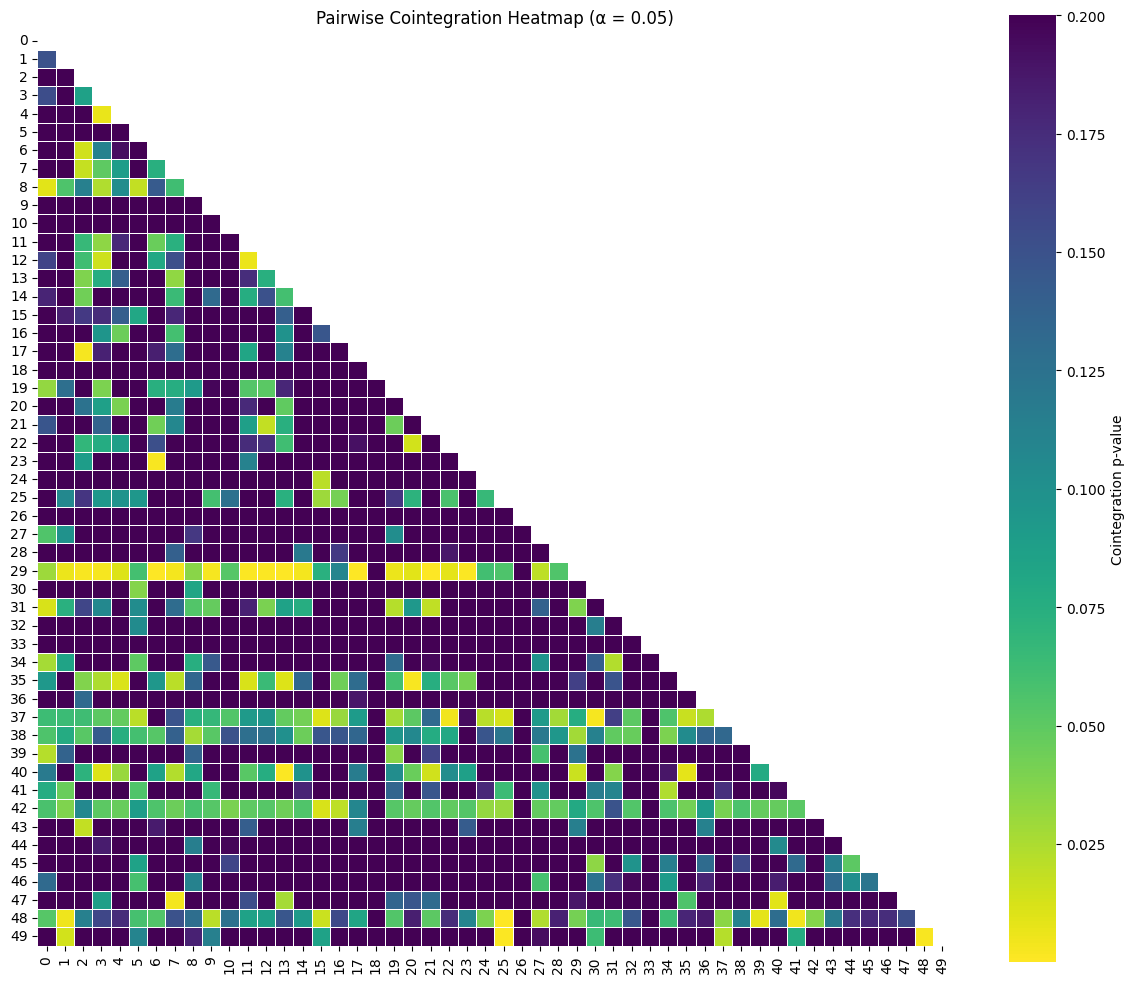

Found 115 cointegrated pairs with p-value < 0.05
25 & 49 → p = 0.0005
6 & 23 → p = 0.0005
48 & 49 → p = 0.0006
29 & 40 → p = 0.0008
7 & 47 → p = 0.0008
25 & 48 → p = 0.0009
3 & 4 → p = 0.0011
2 & 17 → p = 0.0023
11 & 17 → p = 0.0029
13 & 40 → p = 0.0031
11 & 12 → p = 0.0032
2 & 23 → p = 0.0035
17 & 29 → p = 0.0039
37 & 49 → p = 0.0043
35 & 40 → p = 0.0046
40 & 47 → p = 0.0054
29 & 31 → p = 0.0057
35 & 47 → p = 0.0074
29 & 41 → p = 0.0075
29 & 39 → p = 0.0077
12 & 40 → p = 0.0079
29 & 47 → p = 0.0080
2 & 6 → p = 0.0094
37 & 48 → p = 0.0094
3 & 12 → p = 0.0096
42 & 48 → p = 0.0098
41 & 48 → p = 0.0098
8 & 30 → p = 0.0098
31 & 40 → p = 0.0101
3 & 40 → p = 0.0103
20 & 35 → p = 0.0103
37 & 46 → p = 0.0108
31 & 34 → p = 0.0111
15 & 24 → p = 0.0120
0 & 39 → p = 0.0126
29 & 48 → p = 0.0126
7 & 13 → p = 0.0127
29 & 43 → p = 0.0127
8 & 19 → p = 0.0136
9 & 19 → p = 0.0137
8 & 40 → p = 0.0140
8 & 34 → p = 0.0159
2 & 13 → p = 0.0160
12 & 21 → p = 0.0165
21 & 29 → p = 0.0171
8 & 39 → p = 0.0171
2 & 

In [263]:
def compute_cointegration_pval_matrix_with_params(prc_matrix, adf_alpha=0.1):
    """
    Computes pairwise cointegration p-values from OLS residuals and returns
    corresponding alpha and beta matrices. Skips pairs if either instrument is
    individually stationary based on ADF test.

    Parameters:
        prc_matrix (ndarray): (n_instruments, n_days) price matrix
        adf_alpha (float): significance level for skipping stationary instruments (default 0.1)

    Returns:
        pval_matrix (ndarray): cointegration p-values
        beta_matrix (ndarray): OLS slope for each pair
        alpha_matrix (ndarray): OLS intercept for each pair
    """
    n = prc_matrix.shape[0]
    pval_matrix = np.ones((n, n))
    beta_matrix = np.full((n, n), np.nan)
    alpha_matrix = np.full((n, n), np.nan)

    # Check for stationarity of individual instruments
    stationary_flags = []
    for i in range(n):
        price = prc_matrix[i]
        price = price[~np.isnan(price)]
        if len(price) < 30:
            stationary_flags.append(True)  # treat short series as stationary to skip
            continue
        stat, pval, *_ = adfuller(price)
        stationary_flags.append(pval < adf_alpha)

    # Pairwise cointegration test via OLS residuals
    for i in range(n):
        for j in range(n):
            if i == j:
                continue
            if stationary_flags[i] or stationary_flags[j]:
                continue  # skip if either series is stationary

            price_i = prc_matrix[i]
            price_j = prc_matrix[j]

            # Drop aligned NaNs
            mask = ~np.isnan(price_i) & ~np.isnan(price_j)
            if np.sum(mask) < 30:
                continue

            y = price_i[mask]
            x = price_j[mask]
            x_const = sm.add_constant(x)
            model = sm.OLS(y, x_const).fit()
            residuals = model.resid

            try:
                adf_stat, pval, *_ = adfuller(residuals)
                pval_matrix[i, j] = pval
                beta_matrix[i, j] = model.params[1]
                alpha_matrix[i, j] = model.params[0]
            except:
                # If regression or adfuller fails, leave values at default
                pass

    return pval_matrix, beta_matrix, alpha_matrix

def plot_cointegration_heatmap(pval_matrix, alpha=0.05, tickers=None):
    """
    Plot heatmap of cointegration p-values with optional significance masking.

    Parameters:
        pval_matrix (ndarray): (n, n) matrix of p-values
        alpha (float): Significance threshold (e.g., 0.05)
        tickers (list[str]): Optional list of labels
    """
    mask = np.triu(np.ones_like(pval_matrix, dtype=bool))
    sig_mask = (pval_matrix > alpha)
    if tickers is None:
        tickers = [f"{i}" for i in range(pval_matrix.shape[0])]

    plt.figure(figsize=(12, 10))
    sns.heatmap(pval_matrix,
                mask=mask,
                cmap='viridis_r',
                annot=False,
                fmt=".2f",
                cbar_kws={"label": "Cointegration p-value"},
                linewidths=0.5,
                square=True,
                xticklabels=tickers,
                yticklabels=tickers,
                vmax=0.2)  # upper limit set to emphasize low p-values
    plt.title(f'Pairwise Cointegration Heatmap (α = {alpha})')
    plt.tight_layout()
    plt.show()

def get_significant_cointegrated_pairs(pval_matrix, beta_matrix, alpha=0.05, tickers=None, low_beta=0.7, high_beta=1.3):
    """
    Extracts and prints all instrument pairs with cointegration p-values below alpha.

    Parameters:
        pval_matrix (ndarray): (n, n) matrix of cointegration p-values
        alpha (float): significance level threshold
        tickers (list of str, optional): list of instrument names

    Returns:
        List of tuples: [(i, j, pval), ...] where i < j and pval < alpha
    """
    n = pval_matrix.shape[0]
    pairs = []

    for i in range(n):
        for j in range(i + 1, n):
            pval = pval_matrix[i, j]
            beta = beta_matrix[i, j]
            if pval < alpha and low_beta <= beta and beta <= high_beta:
                name_i = tickers[i] if tickers else i
                name_j = tickers[j] if tickers else j
                pairs.append((name_i, name_j, pval))

    print(f"Found {len(pairs)} cointegrated pairs with p-value < {alpha}")
    for name_i, name_j, pval in sorted(pairs, key=lambda x: x[2]):
        print(f"{name_i} & {name_j} → p = {pval:.4f}")

    return pairs

def plot_cointegrated_pair_spread(prc_matrix, i, j, beta_matrix, alpha_matrix, show_residual=False):
    """
    Plots the price of instrument i and the linear combination (alpha + beta * price_j) of instrument j.

    Parameters:
        prc_matrix (ndarray): (n_instruments, n_days) price matrix
        i (int): index of first instrument
        j (int): index of second instrument
        beta_matrix (ndarray): matrix of OLS betas
        alpha_matrix (ndarray): matrix of OLS alphas
        show_residual (bool): whether to plot residual spread
    """
    price_i = prc_matrix[i]
    price_j = prc_matrix[j]

    # Drop NaNs while keeping alignment
    mask = ~np.isnan(price_i) & ~np.isnan(price_j)
    if np.sum(mask) < 30:
        print("Insufficient data after NaN removal.")
        return

    price_i = price_i[mask]
    price_j = price_j[mask]

    beta = beta_matrix[i, j]
    alpha = alpha_matrix[i, j]
    hedge_line = alpha + beta * price_j
    residual = price_i - hedge_line

    plt.figure(figsize=(12, 5))
    plt.plot(price_i, label=f'Instrument {i} Price', linewidth=2)
    plt.plot(hedge_line, label=f'Hedge Line: α + β·Instrument {j}', linestyle='--', linewidth=2)

    if show_residual:
        plt.plot(residual, label="Residual (Spread)", color='gray', alpha=0.5)

    plt.title(f"Cointegrated Pair: {i} & {j} | β = {beta:.2f}, α = {alpha:.2f}")
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

alpha_1 = 0.05
pval_matrix, beta_matrix, alpha_matrix = compute_cointegration_pval_matrix_with_params(prcTest, adf_alpha=alpha_1) # alpha excludes already stationary ones!
plot_cointegration_heatmap(pval_matrix, alpha=0.05)
significant_pairs = get_significant_cointegrated_pairs(pval_matrix, beta_matrix, alpha=alpha_1, low_beta=-10, high_beta=10)


In [ ]:

for (i, j, p) in significant_pairs[:]:  # Top 5 pairs
    plot_cointegrated_pair_spread(prcCheckPrev, i, j, beta_matrix, alpha_matrix)

In [264]:
def evaluate_mean_reversion(prc_future, i, j, beta_matrix, alpha_matrix, plot=True):
    """
    Evaluates mean reversion on a cointegrated pair using future price data.

    Parameters:
        prc_train (ndarray): (n_instruments, n_days_train) training price data
        prc_future (ndarray): (n_instruments, n_days_future) future price data
        i (int): Index of instrument A
        j (int): Index of instrument B
        beta_matrix (ndarray): beta hedge ratio matrix from training
        alpha_matrix (ndarray): alpha intercept matrix from training
        plot (bool): Whether to plot the spread and mean line

    Returns:
        adf_stat (float): ADF statistic on the spread during future period
        pval (float): p-value from ADF test
        spread (ndarray): time series of the spread
    """
    if np.isnan(beta_matrix[i, j]) or np.isnan(alpha_matrix[i, j]):
        print("Warning: No regression values available for this pair.")
        return None, None, None

    beta = beta_matrix[i, j]
    alpha = alpha_matrix[i, j]

    price_a = prc_future[i]
    price_b = prc_future[j]

    # Drop aligned NaNs
    mask = ~np.isnan(price_a) & ~np.isnan(price_b)
    price_a = price_a[mask]
    price_b = price_b[mask]

    if len(price_a) < 30:
        print("Insufficient data in future period.")
        return None, None, None

    # Compute spread = A - β * B - α
    spread = price_a - beta * price_b - alpha

    # Perform ADF test on the spread
    adf_result = adfuller(spread)
    adf_stat = adf_result[0]
    pval = adf_result[1]

    if plot:
        plt.figure(figsize=(10, 4))
        plt.plot(spread, label="Spread (A - βB - α)", color='teal')
        plt.axhline(spread.mean(), color='red', linestyle='--', label='Mean')
        plt.title(f"Spread in Future Period - Inst {i} & {j} - (ADF p-value = {pval:.4f})")
        plt.xlabel("Time")
        plt.ylabel("Spread")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    return adf_stat, pval, spread


def evaluate_mean_reversion_change(prc_train, prc_future, i, j, beta_matrix, alpha_matrix, plot=True):
    """
    Evaluates change in cointegration strength (ADF p-value) by comparing training vs full period.

    Parameters:
        prc_train (ndarray): (n_instruments, n_days_train)
        prc_future (ndarray): (n_instruments, n_days_future)
        i (int): Index of instrument A
        j (int): Index of instrument B
        beta_matrix (ndarray): Trained beta matrix
        alpha_matrix (ndarray): Trained alpha matrix
        plot (bool): If True, plots full spread and mean

    Returns:
        pval_train (float): ADF p-value on training spread
        pval_full (float): ADF p-value on combined spread
        delta_pval (float): Difference (pval_full - pval_train)
    """
    if np.isnan(beta_matrix[i, j]) or np.isnan(alpha_matrix[i, j]):
        print("No regression coefficients for pair.")
        return None, None, None

    beta = beta_matrix[i, j]
    alpha = alpha_matrix[i, j]

    # Combine data
    price_a = np.concatenate([prc_train[i], prc_future[i]])
    price_b = np.concatenate([prc_train[j], prc_future[j]])

    # Mask to drop nan
    mask = ~np.isnan(price_a) & ~np.isnan(price_b)
    price_a = price_a[mask]
    price_b = price_b[mask]

    # Split into train/full spans after nan removal
    n_train = prc_train.shape[1]
    n_used = len(price_a)
    split_idx = min(n_train, n_used)

    price_a_train = price_a[:split_idx]
    price_b_train = price_b[:split_idx]

    # Compute spreads
    spread_train = price_a_train - beta * price_b_train - alpha
    spread_full = price_a - beta * price_b - alpha

    # ADF tests
    pval_train = adfuller(spread_train)[1]
    pval_full = adfuller(spread_full)[1]
    delta_pval = pval_full - pval_train

    if plot:
        plt.figure(figsize=(10, 4))
        plt.plot(spread_full, label="Spread (A - βB - α)", color='steelblue')
        plt.axvline(split_idx, color='grey', linestyle='--', label='Train/Test Split')
        plt.axhline(np.mean(spread_train), color='red', linestyle='--', label='Train Mean')
        plt.title(f"ADF Inst {i} & {j} - p  (Train: {pval_train:.4f} → Full: {pval_full:.4f}, Δ = {delta_pval:.4f})")
        plt.xlabel("Time")
        plt.ylabel("Spread")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    return pval_train, pval_full, delta_pval

keeping = list()

alpha_2 = 0.01

for (i, j, p) in significant_pairs[:]:  # Top 5 pairs

    pval_train, pval_full, delta_pval = evaluate_mean_reversion_change(
        prcTest, prcCheck,
        i=i, j=j,
        beta_matrix=beta_matrix,
        alpha_matrix=alpha_matrix,
        plot=False
    )
    if pval_full < alpha_2: 
        keeping.append((i, j))


In [266]:
print(keeping)
print(len(keeping))

for i, j in keeping:
    print(beta_matrix[i][j])

[(1, 49), (3, 12), (6, 23), (7, 35), (8, 34), (8, 40), (8, 44), (15, 37), (15, 48), (20, 35), (25, 48), (25, 49), (37, 48), (37, 49), (48, 49)]
15
-2.1482247880970706
0.45271224519572567
-0.35335453691974933
-1.1117795600813256
-0.45946666483450455
0.5031109868690278
-0.4748356098005146
-0.34438307338173957
0.7598865278366899
0.9692023797907136
-1.9930477933123796
-2.4574165970573274
-1.5969160576755128
-2.326476087529398
0.9473244271479571


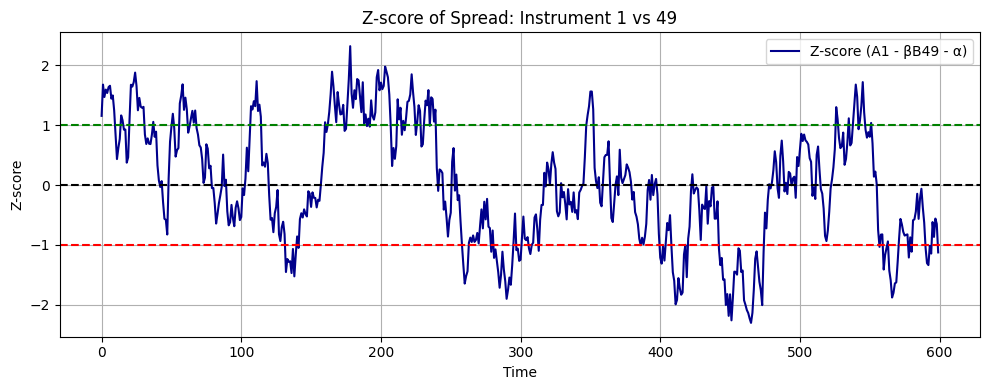

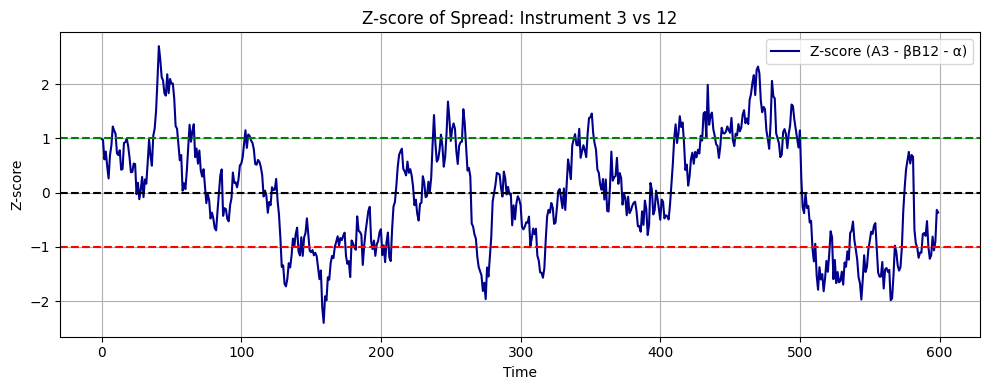

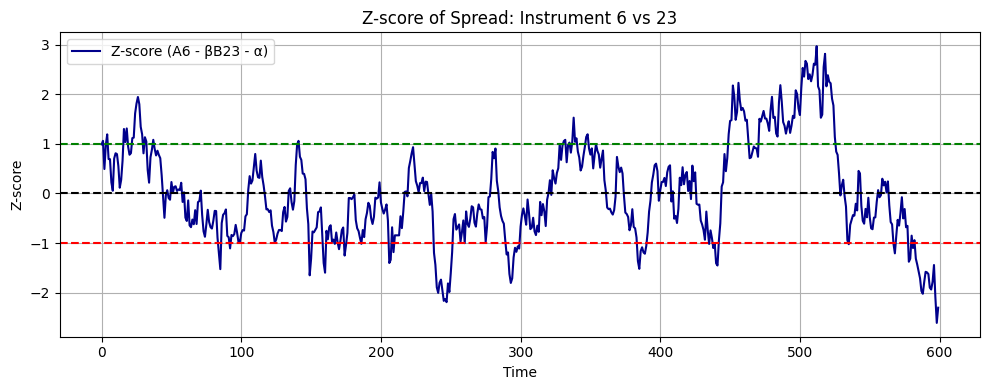

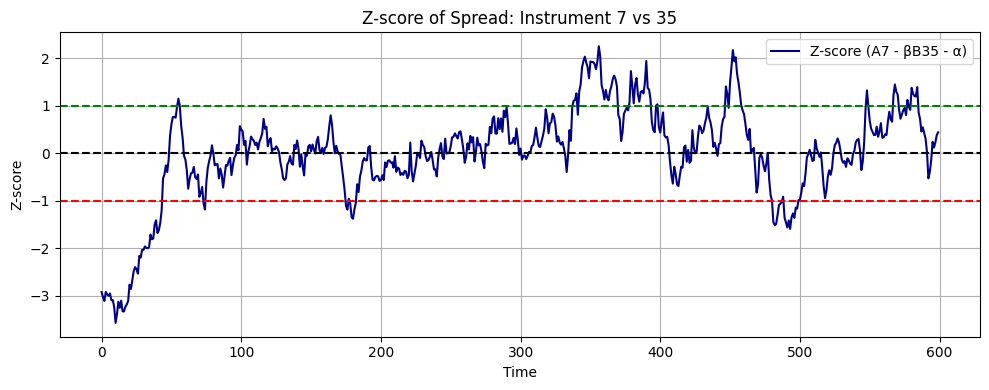

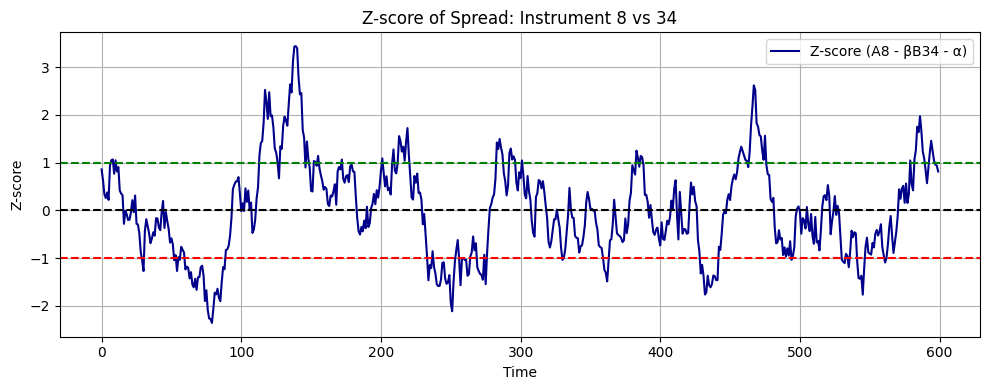

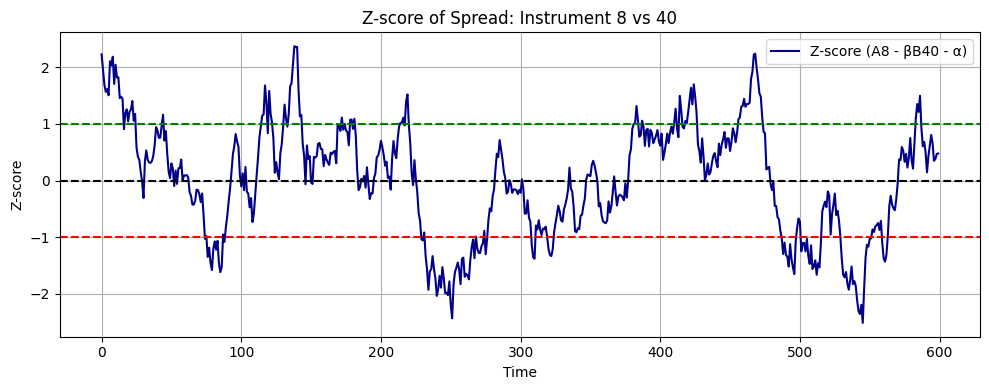

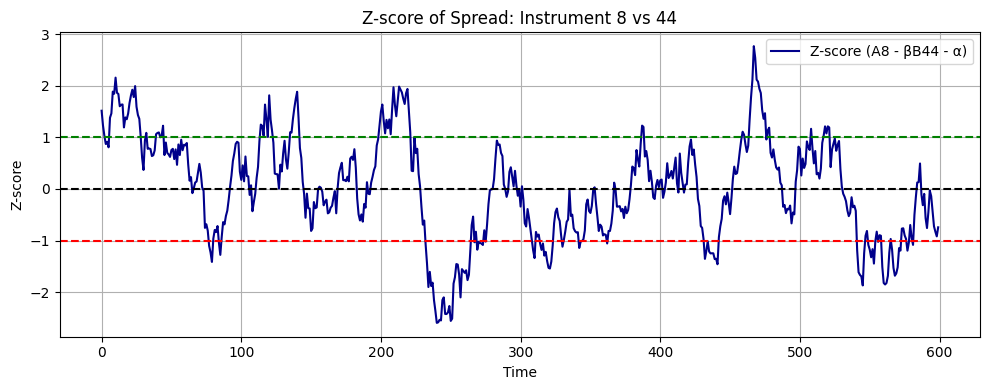

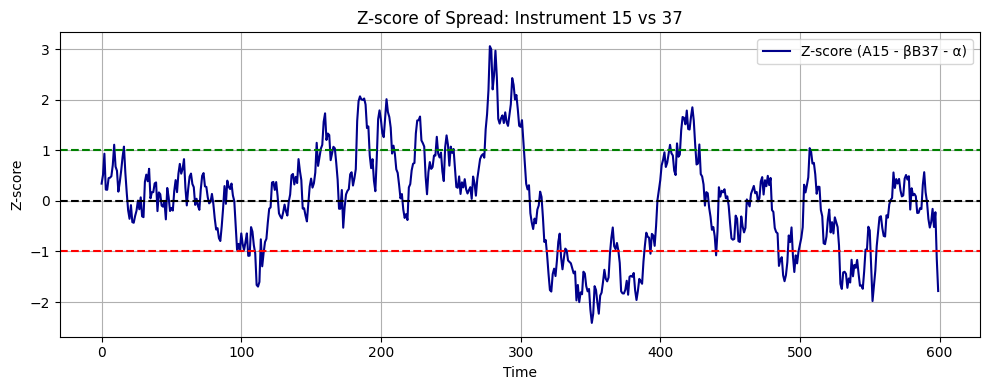

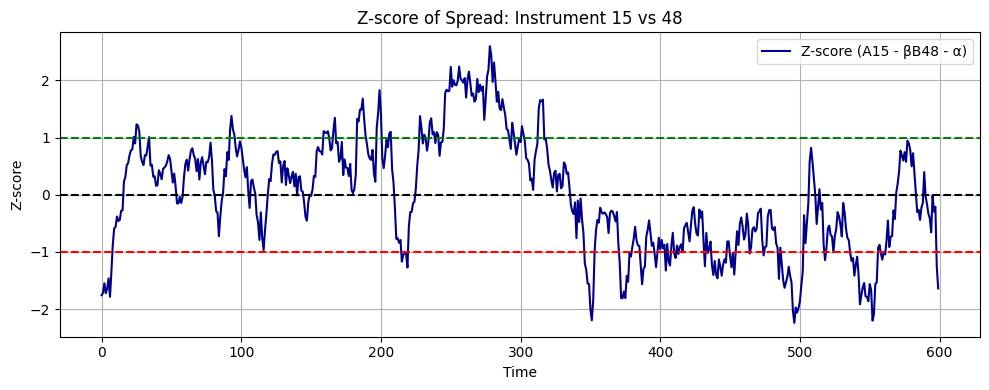

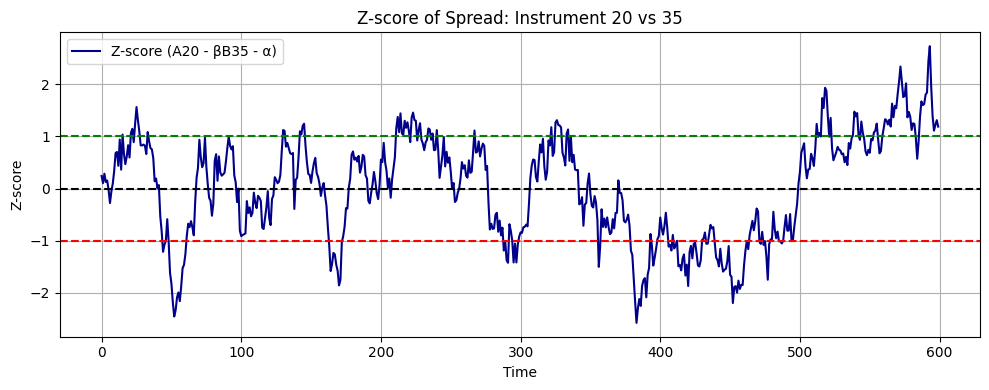

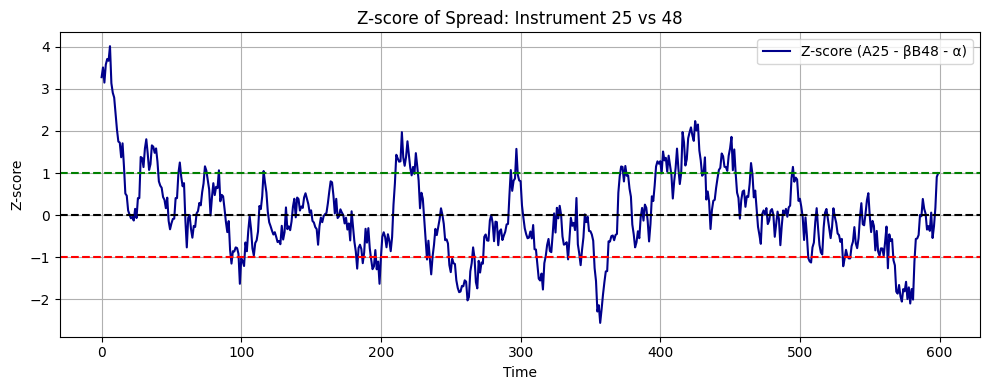

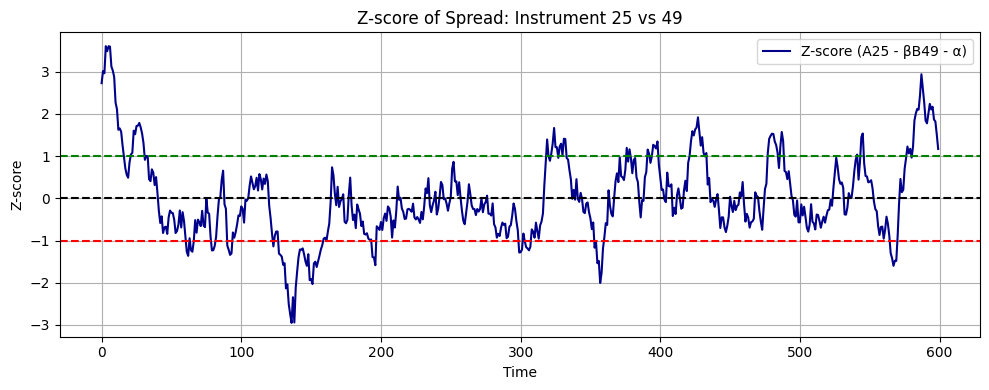

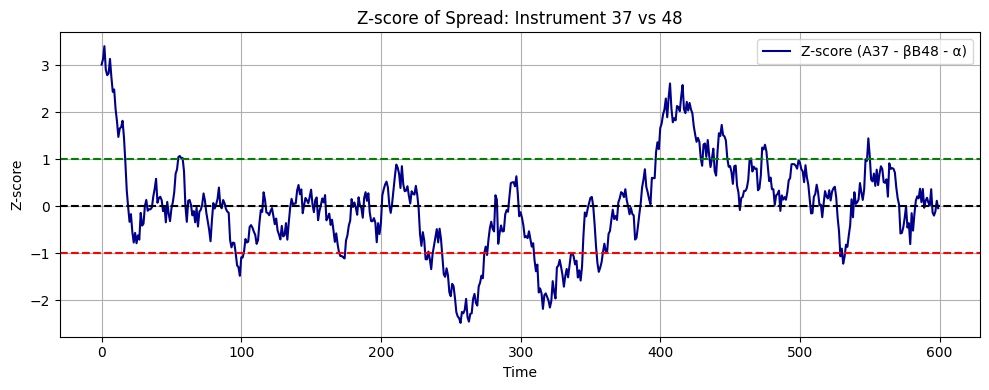

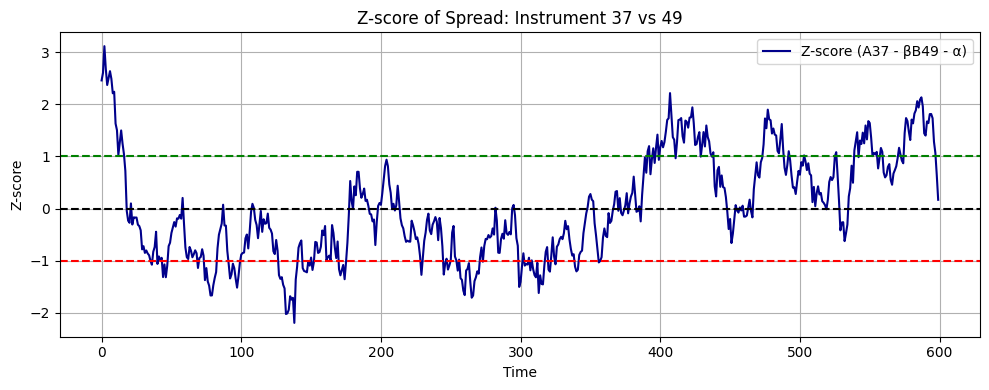

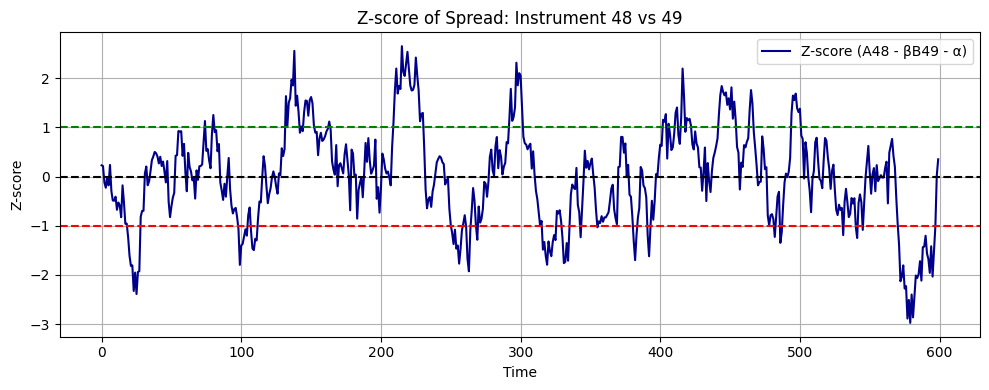

In [268]:
def plot_zscore_spreads(prc_matrix, keeping, beta_matrix, alpha_matrix, save=False, folder="zscore_spreads"):
    """
    Plots the z-score of the spread for each pair in 'keeping' using stored beta and alpha.

    Parameters:
        prc_matrix (ndarray): (n_instruments, n_days) price matrix
        keeping (list of tuples): List of (i, j) index pairs
        beta_matrix (ndarray): Matrix of regression beta values
        alpha_matrix (ndarray): Matrix of regression alpha values
        save (bool): If True, saves the plots to disk
        folder (str): Folder name to save plots (created if not exists)
    """
    import os
    if save and not os.path.exists(folder):
        os.makedirs(folder)

    for i, j in keeping:
        beta = beta_matrix[i, j]
        alpha = alpha_matrix[i, j]

        if np.isnan(beta) or np.isnan(alpha):
            print(f"Skipping pair ({i}, {j}) due to missing beta/alpha.")
            continue

        price_a = prc_matrix[i]
        price_b = prc_matrix[j]

        # Remove nan jointly
        mask = ~np.isnan(price_a) & ~np.isnan(price_b)
        price_a = price_a[mask]
        price_b = price_b[mask]

        if len(price_a) < 10:
            print(f"Skipping pair ({i}, {j}) due to insufficient data.")
            continue

        # Compute spread and z-score
        spread = price_a - beta * price_b - alpha
        spread_mean = np.mean(spread)
        spread_std = np.std(spread)
        zscore = (spread - spread_mean) / spread_std

        # Plot
        plt.figure(figsize=(10, 4))
        plt.plot(zscore, label=f'Z-score (A{i} - βB{j} - α)', color='darkblue')
        plt.axhline(0, linestyle='--', color='black')
        plt.axhline(1, linestyle='--', color='green')
        plt.axhline(-1, linestyle='--', color='red')
        plt.title(f"Z-score of Spread: Instrument {i} vs {j}")
        plt.xlabel("Time")
        plt.ylabel("Z-score")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()

        if save:
            plt.savefig(os.path.join(folder, f"zscore_{i}_{j}.png"))
            plt.close()
        else:
            plt.show()

plot_zscore_spreads(prc_matrix=prcCheckPrev, keeping=keeping, 
                    beta_matrix=beta_matrix, alpha_matrix=alpha_matrix)

In [ ]:
keeping_positive = list()
for i, j in keeping:
    if beta_matrix[i][j] > 0:
        keeping_positive.append((i, j))

print(keeping_positive)


[(3, 12), (8, 40), (15, 48), (20, 35), (48, 49)]


In [274]:
import pickle
final_keep = keeping

# Save everything to a file
with open("mean_reversion_params.pkl", "wb") as f:
    pickle.dump({
        "beta_matrix": beta_matrix,
        "alpha_matrix": alpha_matrix,
        "pairs": final_keep
    }, f)

In [ ]:
# Calculating rolling spearman correlation function
def rolling_spearman(data_arr, inst_1, inst_2, window):
    """
    Computes rolling Spearman correlation between two 1D price series.

    Parameters:
        x (array-like): 1D array of prices for instrument A
        y (array-like): 1D array of prices for instrument B
        window (int): rolling window size (number of days)

    Returns:
        corr_series (np.ndarray): array of Spearman correlations (length = len(x) - window + 1)
    """
    x = np.asarray(data_arr[inst_1])
    y = np.asarray(data_arr[inst_2])

    assert x.shape == y.shape, "Input arrays must be of the same length"
    assert x.ndim == y.ndim == 1, "Inputs must be 1D arrays"
    assert window > 1 and window <= len(x), "Invalid window size"

    corrs = []
    for i in range(len(x) - window + 1):
        x_window = x[i:i + window]
        y_window = y[i:i + window]

        if np.isnan(x_window).any() or np.isnan(y_window).any():
            corrs.append(np.nan)
        else:
            corr, _ = spearmanr(x_window, y_window)
            corrs.append(corr)

    return np.array(corrs)

def plot_colored_rolling_spearman(data_arr, inst_1, inst_2, window=30, high_thresh=0.2, low_thresh=-0.2, normalize=True):
    """
    Plots rolling Spearman correlation with color highlighting for high and low correlation zones.

    Parameters:
        x (array-like): 1D price series of instrument A
        y (array-like): 1D price series of instrument B
        window (int): rolling window size
        high_thresh (float): threshold above which correlation is considered high
        low_thresh (float): threshold below which correlation is considered low
    """
    x = np.asarray(data_arr[inst_1])
    y = np.asarray(data_arr[inst_2])


    assert x.shape == y.shape, "Input arrays must be of same length"
    if normalize:
        x_plot = x / x[0]
        y_plot = y / y[0]
    else:
        x_plot = x
        y_plot = y

    # Compute log returns
    log_ret_x = np.diff(np.log(x))
    log_ret_y = np.diff(np.log(y))

    # Rolling Spearman correlation on log returns
    corrs = []
    for i in range(len(log_ret_x) - window + 1):
        x_win = log_ret_x[i:i + window]
        y_win = log_ret_y[i:i + window]

        if np.isnan(x_win).any() or np.isnan(y_win).any():
            corrs.append(np.nan)
        else:
            c, _ = spearmanr(x_win, y_win)
            corrs.append(c)

    corrs = np.array(corrs)
    t_corr = np.arange(window, len(x))  # Match with price time axis

    # Plot prices with background coloring
    plt.figure(figsize=(14, 6))
    plt.plot(x_plot, label='Instrument A', color='steelblue', linewidth=2)
    plt.plot(y_plot, label='Instrument B', color='darkorange', linewidth=2)

    # Background shading
    for i, t in enumerate(t_corr):
        corr = corrs[i]
        if np.isnan(corr):
            continue
        elif corr >= high_thresh:
            color = 'lightcoral'  # strong positive
        elif corr <= low_thresh:
            color = 'lightblue'   # strong negative
        else:
            color = 'lightgray'   # neutral

        plt.axvspan(t, t + 1, color=color, alpha=0.3, linewidth=0)
    
    plt.title(f"Rolling Spearman Correlation Inst {inst_1} & {inst_2} (window={window})")
    plt.xlabel("Time (Days)")
    plt.ylabel("Normalized Price" if normalize else "Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

inst_2 = 17
window = 30
for i in range(50):
    inst_1 = i

    spearman_corrs = rolling_spearman(data, inst_1, inst_2, window=window)
    plot_colored_rolling_spearman(data, inst_1, inst_2, window=window)

IndexError: index 17 is out of bounds for axis 0 with size 2

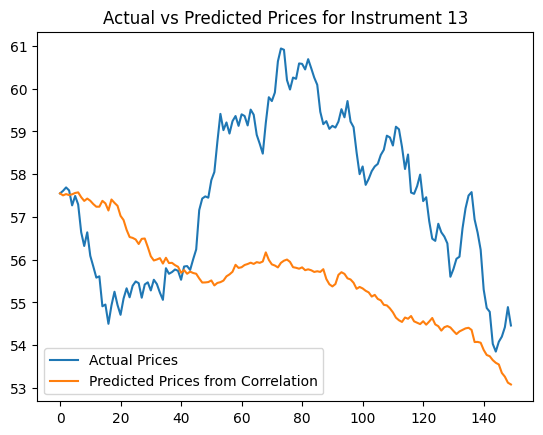

Evaluation for Instrument 13:
Mean Squared Error (MSE): 0.000039
Mean Absolute Error (MAE): 0.004948
R² Score: -0.0144


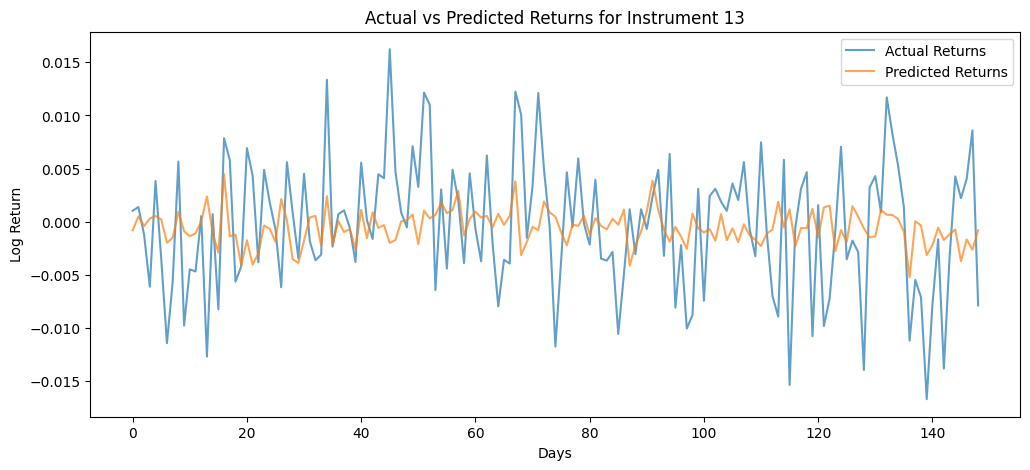

NameError: name 'r2' is not defined

In [ ]:

def predict_instrument_returns(prc_matrix, corr_matrix, target_idx, threshold=0.0):
    """
    Predict the log returns of the target instrument as a weighted sum of
    other instruments' log returns, weighted by their correlation with the target.

    Parameters:
        prc_matrix (ndarray): shape (num_instruments, num_days), closing prices
        corr_matrix (ndarray): shape (num_instruments, num_instruments), correlation matrix of returns
        target_idx (int): index of the instrument to predict

    Returns:
        predicted_returns (ndarray): predicted log returns for the target instrument, shape (num_days-1,)
    """
    n = prc_matrix.shape[0]
    assert corr_matrix.shape == (n, n), "Correlation matrix shape mismatch"

    # Calculate log returns
    log_prices = np.log(prc_matrix)
    log_returns = np.diff(log_prices, axis=1)  # shape (n, num_days-1)

    # Get weights from correlation matrix, zero self-correlation
    weights = corr_matrix[target_idx].copy()
    weights[target_idx] = 0

    # zero out weak correlation
    weights[np.abs(weights) < threshold] = 0

    # Normalize weights by sum of absolute values to keep scale
    sum_weights = np.sum(np.abs(weights))
    if sum_weights != 0:
        weights /= sum_weights

    # Weighted sum of other instruments' returns to predict target returns
    predicted_returns = weights @ log_returns  # shape (num_days-1,)

    return predicted_returns


def reconstruct_price_from_returns(start_price, returns):
    """
    Reconstruct price series from starting price and log returns.

    Parameters:
        start_price (float): initial price before returns start
        returns (ndarray): log returns array shape (num_days-1,)

    Returns:
        prices (ndarray): reconstructed price series shape (num_days,)
    """
    cum_log_return = np.cumsum(returns)
    prices = start_price * np.exp(cum_log_return)
    prices = np.insert(prices, 0, start_price)  # include starting price
    return prices


def evaluate_predicted_returns(prc_matrix, predicted_returns, target_idx):
    """
    Compare predicted returns with actual returns and compute metrics.

    Parameters:
        prc_matrix (ndarray): (num_instruments, num_days) price matrix
        predicted_returns (ndarray): predicted log returns for target instrument, shape (num_days-1,)
        target_idx (int): index of the instrument being predicted

    Returns:
        metrics (dict): mse, mae, r2 scores
    """
    # Calculate actual log returns
    log_prices = np.log(prc_matrix)
    actual_returns = np.diff(log_prices[target_idx])

    # Metrics
    mse = mean_squared_error(actual_returns, predicted_returns)
    mae = mean_absolute_error(actual_returns, predicted_returns)
    r2 = r2_score(actual_returns, predicted_returns)

    print(f"Evaluation for Instrument {target_idx}:")
    print(f"Mean Squared Error (MSE): {mse:.6f}")
    print(f"Mean Absolute Error (MAE): {mae:.6f}")
    print(f"R² Score: {r2:.4f}")

    # Plot actual vs predicted returns
    plt.figure(figsize=(12, 5))
    plt.plot(actual_returns, label='Actual Returns', alpha=0.7)
    plt.plot(predicted_returns, label='Predicted Returns', alpha=0.7)
    plt.title(f'Actual vs Predicted Returns for Instrument {target_idx}')
    plt.xlabel('Days')
    plt.ylabel('Log Return')
    plt.legend()
    plt.show()

    return {'mse': mse, 'mae': mae, 'r2': r2}

data = prcCheck
for target_idx in [13, 44, 14, 16, 33]:
    predicted_ret = predict_instrument_returns(data, corr_matrix, target_idx, 0.05)

    # Reconstruct predicted prices starting from actual first price
    predicted_prices = reconstruct_price_from_returns(data[target_idx, 0], predicted_ret)

    plt.plot(data[target_idx], label="Actual Prices")
    plt.plot(predicted_prices, label="Predicted Prices from Correlation")
    plt.legend()
    plt.title(f"Actual vs Predicted Prices for Instrument {target_idx}")
    plt.show()
    metrics = evaluate_predicted_returns(data, predicted_ret, target_idx)
    r2.append(metrics['r2'])
print(r2)
    

In [ ]:
# Running granger causality tests!
def run_granger_causality_tests_by_index(returns_df, target_idx, max_lag=5, alpha=0.05, verbose=False):
    """
    Runs Granger causality tests from every instrument to a target instrument by index.

    Parameters:
        returns_df (pd.DataFrame): shape (days, instruments)
        target_idx (int): Index of the target instrument (column in DataFrame)
        max_lag (int): Max lag to test
        alpha (float): Significance level
        verbose (bool): If True, print test output

    Returns:
        pd.DataFrame: summary of p-values and significance
    """
    results = []

    for predictor_idx in returns_df.columns:
        if predictor_idx == target_idx:
            continue

        # Format: [target, predictor]
        data = returns_df[[target_idx, predictor_idx]].dropna().to_numpy()

        try:
            test_result = grangercausalitytests(data, maxlag=max_lag)
        except Exception as e:
            print(f"Error testing {predictor_idx} → {target_idx}: {e}")
            continue

        min_pval = min(test_result[lag][0]['ssr_ftest'][1] for lag in range(1, max_lag + 1))

        results.append({
            'Predictor': predictor_idx,
            'Target': target_idx,
            'Min_p_value': min_pval,
            'Significant': min_pval < alpha
        })

    return pd.DataFrame(results).sort_values(by='Min_p_value')

def plot_granger_results(results_df, alpha=0.05, target_idx=None):
    """
    Plots Granger causality results as a bar chart of minimum p-values.

    Parameters:
        results_df (pd.DataFrame): Output of run_granger_causality_tests_by_index
                                   Must contain columns ['Predictor', 'Min_p_value', 'Significant']
        alpha (float): Significance level used in test
        target_idx (int or str, optional): Target instrument index or name for title
    """
    plt.figure(figsize=(12, 6))

    bars = plt.bar(
        results_df['Predictor'].astype(str),
        results_df['Min_p_value'],
        color=['red' if sig else 'gray' for sig in results_df['Significant']]
    )

    plt.axhline(y=alpha, color='blue', linestyle='--', label=f'Alpha = {alpha}')
    plt.xlabel('Predictor Instrument')
    plt.ylabel('Minimum p-value')
    plt.title(f'Granger Causality to Target {target_idx}' if target_idx is not None else 'Granger Causality Results')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

def top_5_significant_granger(returns_df, target_idx, max_lag=5, alpha=0.05):
    """
    Runs Granger causality tests from all instruments to target_idx,
    then extracts top 5 most significant causal relationships with lag info.

    Parameters:
        returns_df (pd.DataFrame): shape (days, instruments)
        target_idx (int): target instrument index
        max_lag (int): max lag to test
        alpha (float): significance threshold

    Returns:
        pd.DataFrame with columns:
          - Predictor (int)
          - Best_Lag (int)
          - Min_p_value (float)
          - Significant (bool)
          - Description (str)
    """
    records = []

    for predictor_idx in returns_df.columns:
        if predictor_idx == target_idx:
            continue

        data = returns_df[[target_idx, predictor_idx]].dropna().to_numpy()

        try:
            test_result = grangercausalitytests(data, maxlag=max_lag)
        except Exception as e:
            print(f"Error testing {predictor_idx} → {target_idx}: {e}")
            continue

        # Extract lag with smallest p-value
        lag_pvals = []
        for lag in range(1, max_lag + 1):
            pval = test_result[lag][0]['ssr_ftest'][1]
            lag_pvals.append((lag, pval))
        best_lag, min_pval = min(lag_pvals, key=lambda x: x[1])
        significant = min_pval < alpha

        description = (
            f"Predictor {predictor_idx} Granger-causes Target {target_idx} "
            f"at lag {best_lag} with p-value={min_pval:.4g} "
            f"{'(Significant)' if significant else '(Not significant)'}"
        )

        records.append({
            'Predictor': predictor_idx,
            'Best_Lag': best_lag,
            'Min_p_value': min_pval,
            'Significant': significant,
            'Description': description
        })

    df = pd.DataFrame(records)
    df_sorted = df.sort_values(by='Min_p_value').head(5).reset_index(drop=True)
    return df_sorted
data = prcTest
# Suppose 'returns_df' is a DataFrame with daily returns, columns = tickers
log_returns = np.diff(np.log(data), axis=1)
# Transpose and convert to DataFrame so columns = instruments, rows = time
returns_df = pd.DataFrame(log_returns.T, columns=np.arange(log_returns.shape[0]))
alpha = 0.01
target_inst = 0
granger_results = run_granger_causality_tests_by_index(returns_df, target_idx=target_inst, max_lag=5, alpha=alpha)

plot_granger_results(granger_results, alpha=alpha, target_idx=0)
top5 = top_5_significant_granger(returns_df, target_idx=target_inst, max_lag=5, alpha=0.05)
# print(top5[['Predictor', 'Best_Lag', 'Min_p_value', 'Significant']])

In [ ]:

print(top5[['Predictor', 'Best_Lag', 'Min_p_value', 'Significant']])

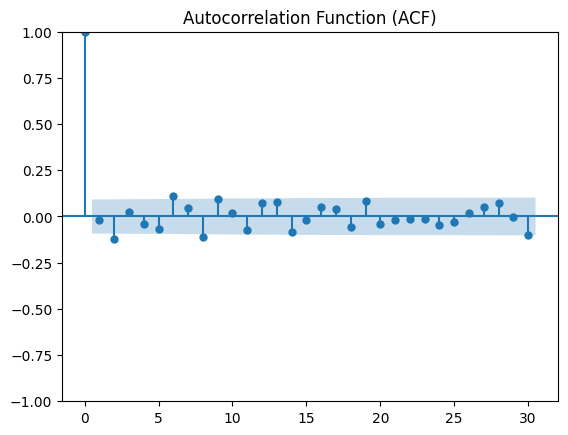

(449,)

In [ ]:

data = prcTest
# Suppose 'returns_df' is a DataFrame with daily returns, columns = tickers
inst_target = 0
inst_prc = data[inst_target, :]
log_returns = np.diff(np.log(inst_prc))
plot_acf(log_returns, lags=30)
plt.title('Autocorrelation Function (ACF)')
plt.show()
log_returns.shape

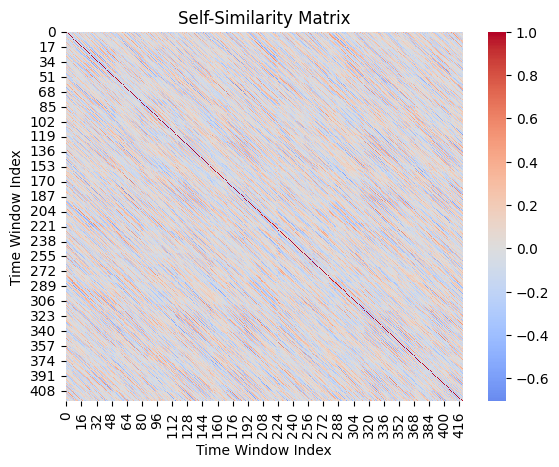

In [ ]:
def self_similarity_matrix(series, window=30):
    """
    Computes correlation between all sliding windows of the time series.

    Returns:
        matrix (2D array): (n_windows x n_windows) correlation matrix
    """
    series = np.array(series)
    n = len(series) - window + 1
    matrix = np.empty((n, n))

    # Extract all sliding windows
    segments = np.array([series[i:i+window] for i in range(n)])

    for i in range(n):
        for j in range(n):
            matrix[i, j] = np.corrcoef(segments[i], segments[j])[0, 1]

    return matrix

# Compute and visualize
sim_matrix = self_similarity_matrix(log_returns, window=30)

sns.heatmap(sim_matrix, cmap='coolwarm', center=0)
plt.title("Self-Similarity Matrix")
plt.xlabel("Time Window Index")
plt.ylabel("Time Window Index")
plt.show()
